<header><h1>Multivariate Analysis | Part 2</h1></header>
<h2>Clustering, PCA and Analysis on Customer Table</h2>
<h1><strong>Author: </strong> Chimdia Kabuo, Pauline Korukundo, Anushka Bhat</h1>
<h1><strong>Supervisor: </strong> Alessandro Selvitella</h1>

<h3>Install Packages</h3>

<span>Run Once!</span>

In [36]:
# Save current warning behavior
old_warning <- getOption("warn")

# Temporarily suppress warnings
options(warn = -1)

# Define a list of packages to install
packages_to_install <- c("reshape2", "car", "FactoMineR", "GGally", "dbscan", "factoextra", "gridExtra")

# Install and load each package if not already installed
for (package in packages_to_install) {
  if (!requireNamespace(package, quietly = TRUE)) {
    install.packages(package)
  }
}

cat("Done")

# Restore original warning behavior
options(warn = old_warning)

Done

<h3>Load Packages</h3>

In [39]:
library(lubridate)
library(tidyverse)
library(ggplot2)
library(reshape2)
library(GGally)
library(dplyr)
library(cluster)
library(stats)
library(dbscan)
library(car)
library(FactoMineR)
library(factoextra)
library(gridExtra)

cat("Done")

Done

In [38]:
# Set global display option to avoid scientific notation
options(scipen = 999)

<h2>Setting Up The Dataset</h2>
<p>Creating Functions - Clean Data and Get Eligible Population</p>
<p>Intersect the dataset with the eligible population</p>

<h3>Function | Clean Data</h3>

In [7]:
## remove leading/trailing white space, convert blank cells to NA, convert POSIX object to Date, and convert from character to numeric where appropriate
Clean_Data_fx <- function(df1){
  ## Convert blanks to NA. Need to do this outside of dtplyr to recover type
  df1 <- map_df(df1, function(x){
    # Everything will be convert to character type. Capture the type to later convert back
    Type_use <- switch(match(typeof(x), c("logical", "integer", "double", "character")),
                       as.logical,
                       as.integer,
                       as.double,
                       as.character)
    
    Convert <- map_lgl(class(x), function(y){
      y %in% c("POSIXct", "POSIXt", "Date")
    })
    
    if(any(Convert)){
      return(as.Date(x))
      
    }else if(typeof(x) == "character"){
      return(tryCatch(type.convert(Type_use(gsub("^$", NA, trimws(x))), as.is = TRUE), error = function(e) x))
      
    }else{
      return(tryCatch(type.convert(Type_use(gsub("^$", NA, x)), as.is = TRUE), error = function(e) x))
    }
    
  })
  
  df1 <- df1 %>% mutate(across(where(is.factor), ~ as.character(.x)))
  
  return(df1)
  
}

<h3>Function | Get Eligible Population</h3>

In [8]:
## 3 months from end of August. Used to determine eligible members and checking and savings accounts
Startdate <- as.Date("2023-06-01", origin = "1970-01-01")


## Start with customer data to determine elgibility then look at account data
df_Cust <- readRDS('/home/x-ckabuo/corporate/3rivers-membership/projects/x-ckabuo/data/Customer_Table.rds')

## active member from at least June 1st 2023 and is currently active the customer type is "Personal" and the member is at least 18 years old
ID_use <- df_Cust %>%
  Clean_Data_fx(.) %>%          ## this is a self-written function to clean the data
  filter(datejoined < Startdate,
         isactive == "Yes",
         type == "Personal",
         age >= 18) %>%
  pull(id)
  
## read in customer to account table
df_CtA <- readRDS('/home/x-ckabuo/corporate/3rivers-membership/projects/x-ckabuo/data/CustomerToAccount_Table.rds')

## member needs to have an active checking or savings account that was opened before June 1st. 
# Doesn't matter if they are the primary on the account. Use the customer to account table because the account table will only have primary member
df_Population <- df_CtA %>%
  filter(application %in% c("CH", "SV")) %>%
  Clean_Data_fx(.) %>%                          ## this is a self-written function to clean the data
  filter(customerid %in% ID_use,
         startdatetime < Startdate,
         isactive == "Yes") %>%
  mutate(accountid = as.character(accountid)) ## make account id a string instead of a number


## read in account table. Need the  product market field
df_Acct <- readRDS('/home/x-ckabuo/corporate/3rivers-membership/projects/x-ckabuo/data/Account_Table.rds')

## last step is to check whether any of the checking or saving accounts are "Consumer". If not then drop 
df_Population  <- df_Acct %>%
  select(number, productmarket, productname) %>%
  left_join(df_Population, ., by = c("accountid" = "number")) %>%
  filter(is.na(productmarket == "Consumer") | productmarket == "Consumer",  ## some productmarket labels are missing which would count as "Consumer"
         productname != "Business Money Market") %>%                        #  except "Business Money Market"                     
  distinct(customerid)   ## only want unique customer id. 
  
  ## Need Secondary_ID to identify other memberships of the member. We will want to use that data for the member
df_Population <- df_Cust %>%
  select(customerid = id, Secondary_ID) %>%
  filter(customerid %in% df_Population$customerid) %>%
  mutate(Secondary_ID = ifelse(is.na(Secondary_ID), customerid, Secondary_ID)) ## assigned customerid when secondary is missing to filter when merging

#saveRDS(df_Population, file.path(myPaths$output, "Eligible_Members.rds"))
write.csv(df_Population, file ='/home/x-ckabuo/corporate/3rivers-membership/projects/x-ckabuo/prime/Eligible_Members2.csv')

cat("Done")                      

Done

In [9]:
# Segment the data based on geographical location
segmented_data <- df_Cust %>%
  Clean_Data_fx(.) %>%
  filter(datejoined < Startdate,
         isactive == "Yes",
         type == "Personal",
         age >= 18) %>%
  select(id, datejoined) %>%
  group_by(datejoined) %>%
  summarize(num_members = n())

# Print the segmented data
print(segmented_data)

# A tibble: 12,484 x 2
   datejoined num_members
   <date>           <int>
 1 1194-10-20           1
 2 1935-08-26           1
 3 1947-04-22           2
 4 1953-09-30           1
 5 1956-09-29           1
 6 1960-01-01           1
 7 1972-01-01           1
 8 1972-07-07           1
 9 1973-09-28           1
10 1974-03-19           2
# i 12,474 more rows


<h3>Intersect Selected Data Variables</h3>
<p>Intersect selected data variables from eligible population</p>

In [10]:
I5=intersect(df_Cust['id'][,1], df_Population['customerid'][,1])

<p>Check length of the intersect</p>

In [11]:
length(I5)

[1] 127217

<h3>Check Number of Unique Rows</h3>

In [12]:
row_index5 <- c()
for (j in 1:length(I5)) {
row_index5 <- c(row_index5,which(df_Cust['id'] == I5[j]))
}
row_index5 <- unique(row_index5)
head(row_index5)

[1] 166 169 171 172 173 174

<h4>Define dataframe to hold the eligible data</h4>

In [13]:
# data frame to hold the selected variables based on the indices specified in `row_index5`
df_Cust_5 <- df_Cust[row_index5,]

<h2>Descriptive Analysis</h2>

<h3>Extract Numeric Columns from the Selected Data variables</h3>

In [14]:
##**** Identify numeric columns ****##
numCols <- unlist(lapply(df_Cust_5, is.numeric))

##**** Print Subset of Numeric Columns ****##
CustNum <- df_Cust_5[, numCols]

<h4>Replacing NAs & Blank values with 0 </h4>
<span>This is done because there are an overwhelming number of NAs in the dataset which could cause issues with analysis and visualization</span>

In [15]:
# Replace NA values with 0
CustNum[is.na(CustNum)] <- 0

<span>Replacing blank values with 0</span>

In [16]:
# Replace blank values
CustNum[CustNum == ""] <- 0

<h5>Explanation</h5>
<p>We can see that the dimensions remain the same but the summary/description of the data has improved; the NAs are no longer present.</p>

<h4>Checking for Unique Values</h4>
<p>Since some of our columns appear to have fewer unique values, we will test to see if this is true</p>

In [17]:
# Check for unique values in all columns of our data
unique_values <- sapply(CustNum, function(x) length(unique(x)))
unique_values

age               ageatjoining 
                        89                        105 
 autoloansprincipalbalance           cdaccountbalance 
                     17995                       3951 
    checkingaccountbalance      closestbranchdistance 
                     61660                       7042 
          dayssincejoining       demandaccountbalance 
                     12454                      79404 
         iraaccountbalance  mortgagesprincipalbalance 
                       432                      11507 
       numberofcreditcards         numberofdebitcards 
                        10                         20 
          numberofaccounts          numberofautoloans 
                        40                         16 
        numberofcdaccounts   numberofcheckingaccounts 
                        24                         21 
   numberofhomeequityloans              numberofloans 
                         3                         20 
         numberofmortgages    numberofsavingsaccounts 
                         9                         22 
totalloansprincipalbalance   transactionamount_last30 
                     34444                      71294 
   transactioncount_last30                  HH_Number 
                       362                      69983

<h3>Generate a set of boxplots for each variable in the `Custnum` data frame</h3>
<span>The `HH_Number` column is used in the visualization as the id variable</span

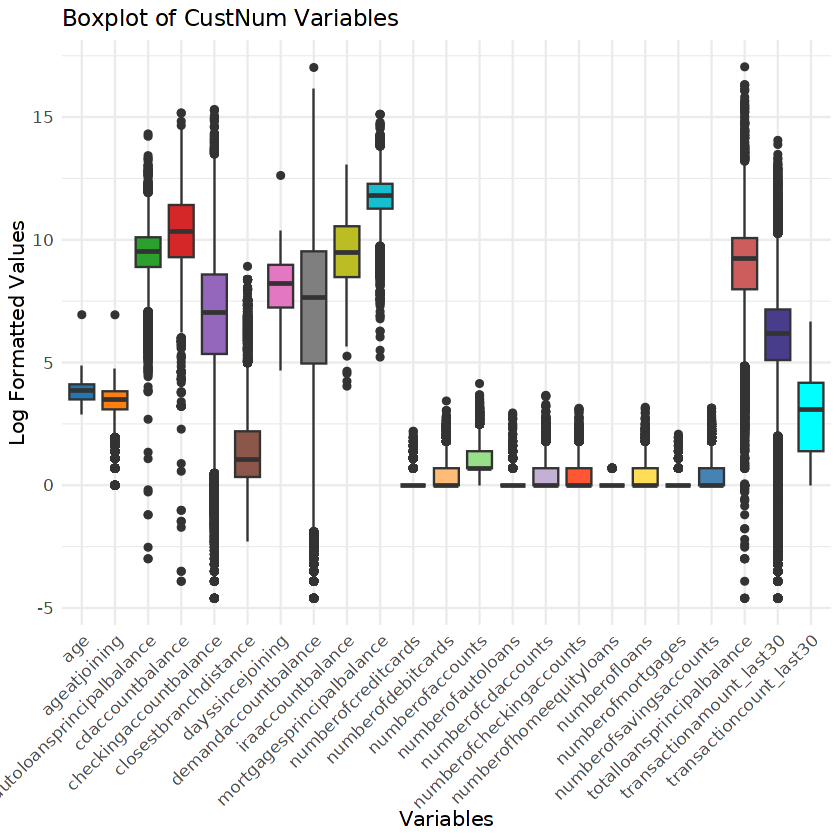

In [18]:
# Save current warning behavior
old_warning <- getOption("warn")

# Temporarily suppress warnings
options(warn = -1)

# Melt the data into long format, using 'HH_Number' as the id variable
melted_data <- reshape2::melt(CustNum, id.vars = "HH_Number")

# Create a custom color palette
my_colors <- c("#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
               "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
               "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
               "#ff5733", "#6a1b9a", "#ffdd57", "#2e8b57", "#4682b4",
               "#cd5c5c", "#483d8b", "#00ffff", "#dda0dd")

# Create a boxplot for each column with custom colors
ggplot(melted_data, aes(x = variable, y = log(value), fill = variable)) +
  geom_boxplot() +
  scale_fill_manual(values = my_colors) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "none",
        panel.spacing = unit(5.0, "lines"),
        strip.text = element_text(face = "bold"),
        axis.text = element_text(size = 10),
        axis.title = element_text(size = 12)) + 
  labs(title = "Boxplot of CustNum Variables",
       x = "Variables",
       y = "Log Formatted Values")

# Restore original warning behavior
options(warn = old_warning)

<h3>Dropping Irrelevant Variables</h3>
<p>John recommends dropping the `hasestatement` variable</p>
<p>Other recommended variables to drop are those that include any "balance" or "transactionamount"</p>

<h4>List Variables to Drop</h4>

In [19]:
# keywords is a vector of keywords we want to drop
keywords <- c("balance", "transaction")

# Find indices of the columns containing the keywords
Vars2Drop <- grep(paste(keywords, collapse = "|"), names(CustNum))

# Drop the columns containing the keywords 
CustNum_drop <- CustNum[, -Vars2Drop]

cat("Done")

Done

<h5>Summary</h5>
<p>After dropping the columns as recommended by John | Using the keywords, we find that 9 columns have been dropped.</p>
<p>We will perform "Clustering", "PCA", and other Analysis on the remaining variables!</p>
<span>However, we can still work with those variables at a later date should we so choose!!</span>

In [20]:
names(CustNum_drop)

[1] "age"                      "ageatjoining"            
 [3] "closestbranchdistance"    "dayssincejoining"        
 [5] "numberofcreditcards"      "numberofdebitcards"      
 [7] "numberofaccounts"         "numberofautoloans"       
 [9] "numberofcdaccounts"       "numberofcheckingaccounts"
[11] "numberofhomeequityloans"  "numberofloans"           
[13] "numberofmortgages"        "numberofsavingsaccounts" 
[15] "HH_Number"

<h2>Clustering Analysis</h2>

<h3>Compute K-means Clustering</h3>
<p>Using Elbow Method and within-cluster sum of squares (WCSS) on the `CustNum_drop` data frame</p>

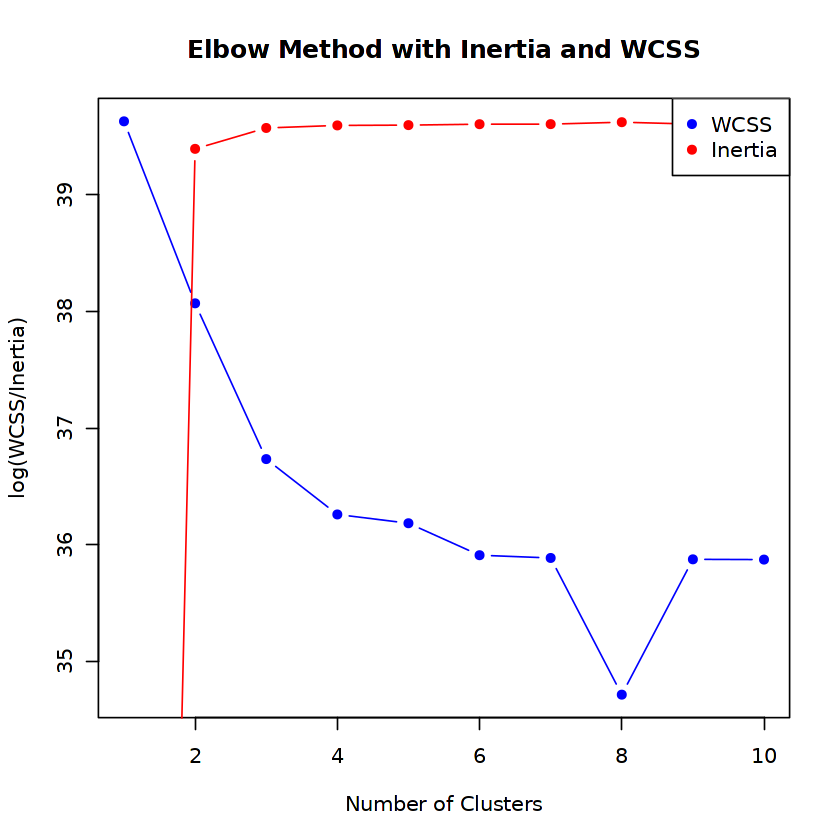

In [21]:
# Create vectors to store the within-cluster sum of squares (WCSS) for different values of k
wcss <- numeric(10)
# Create vectors to store inertia for different values of k
inertia <- numeric(10)

# Define a range of values for k
k_range <- 1:10

# Iterate over each value of k
for (k in k_range) {
  # Compute K-means clustering for dataframe with variables dropped
  kmeans_model <- kmeans(CustNum_drop, centers = k)
  
  # Store the within-cluster sum of squares (WCSS)
  wcss[k] <- kmeans_model$tot.withinss
  
  # Store the inertia
  inertia[k] <- kmeans_model$totss - kmeans_model$tot.withinss
}

# Plot the within-cluster sum of squares (WCSS) and inertia against number of clusters
plot(k_range, log(wcss), type = "b", col = "blue", pch = 16,
     xlab = "Number of Clusters", ylab = "log(WCSS/Inertia)", 
     main = "Elbow Method with Inertia and WCSS")

# Add inertia to the plot
points(k_range, log(inertia), type = "b", col = "red", pch = 16)

# Add legend
legend("topright", legend = c("WCSS", "Inertia"), col = c("blue", "red"), pch = 16)

<h4>Summary</h4>
<p>Using the plot within-cluster sum of squares (WCSS), we look for the `elbow point`, 
    where the rate of decrease in WCSS slows down and might be indicative of a suitable number of clusters.</p>
<p>Using the plot of the inertia helps us to estimate the point where linear decrease starts in the visualization.</p>
<span>In the case of this visualization, the point is <strong>4</strong></span>

<h4>John suggests that we convert both `age` and `ageatjoining` into years</h4>
<p>We will use `dayssincejoining` converted into `yearsofmember`</p>

In [22]:
# Converting `dayssincejoining` to `yearsofmember`
CustNum_drop <- CustNum_drop %>% mutate(yearsofmember = dayssincejoining / 365)

<span>Notice that `ageatjoining` is dropped in the subset</span><br/>
<span>It can be used for other analysis that are not k-means clustering</span><br/>
<em>`df_KMeans1` has one variable extra</em>

<h3>Creating several subsets of the data for performing K-means clustering</h3>

In [23]:
# Create deep copies of the original numerical dataframe `CustNum`
df_KMeans1 <- CustNum_drop[, c("age", "numberofmortgages", "closestbranchdistance", "yearsofmember", "numberofsavingsaccounts")]

df_KMeans2 <- CustNum_drop[, c("yearsofmember", "numberofcreditcards", "numberofdebitcards", "numberofaccounts")]

df_KMeans3 <- CustNum_drop[, c("numberofaccounts", "numberofautoloans", "numberofcdaccounts", "numberofcheckingaccounts")]

df_KMeans4 <- CustNum_drop[, c("numberofcheckingaccounts", "numberofhomeequityloans", "numberofloans", "numberofmortgages")]

cat("Done")

Done

<h4>Summary</h4>
<p>The data we are working with is large and therefore puts a strain on computation</p>
<p>Subsetting the data helps in 
<li>Dimensionality Reduction - which reduces the number of variables to a more manageable size.</li>
<li>Computational Efficiency - because performing kmeans can be computationally expensive as the number of variables increases.</li>
</p>

<h4>Performing K-means Clustering on the subsets of the dataframe</h4>

In [24]:
# Define a function to perform K-means clustering on multiple data frames
perform_kmeans <- function(df_list, k) {
  results <- list()  # Create an empty list to store results
  
  # Iterate over each data frame in the list
  for (i in seq_along(df_list)) {
    # Perform K-means clustering on the current data frame
    kmeans_result <- kmeans(df_list[[i]], centers = k)
    
    # Store cluster assignments and cluster centers in the results list
    results[[i]] <- list(cluster_assignments = kmeans_result$cluster,
                         cluster_centers = kmeans_result$centers)
  }
  
  # Return the list of results
  return(results)
}

# Apply K-means clustering to each dataframe
k <- 4 # Number of clusters

# List of data frames
df_list <- list(df_KMeans1, df_KMeans2, df_KMeans3, df_KMeans4)

# Perform K-means clustering on each data frame
kmeans_results <- perform_kmeans(df_list, k)

# Access the results for each data frame
kmeans1 <- kmeans_results[[1]]
kmeans2 <- kmeans_results[[2]]
kmeans3 <- kmeans_results[[3]]
kmeans4 <- kmeans_results[[4]]


# Combine cluster results into a single list
all_kmeans_result <- list(kmeans1, kmeans2, kmeans3, kmeans4)

head(kmeans1$cluster_centers)

cat("Done")

,age,numberofmortgages,closestbranchdistance,yearsofmember,numberofsavingsaccounts
1,48.09904,0.01898830,648.20418,8.181230,1.063801
2,45.58231,0.01313485,1788.64151,9.680822,1.070053
3,33.59063,0.13244694,17.16868,8.596968,1.214086
4,61.79827,0.17025813,4.40039,18.890147,1.486208


Done

<h3>Visualize only the cluster centers</h3>

<h4>kmeans1 cluster center visualization</h4>

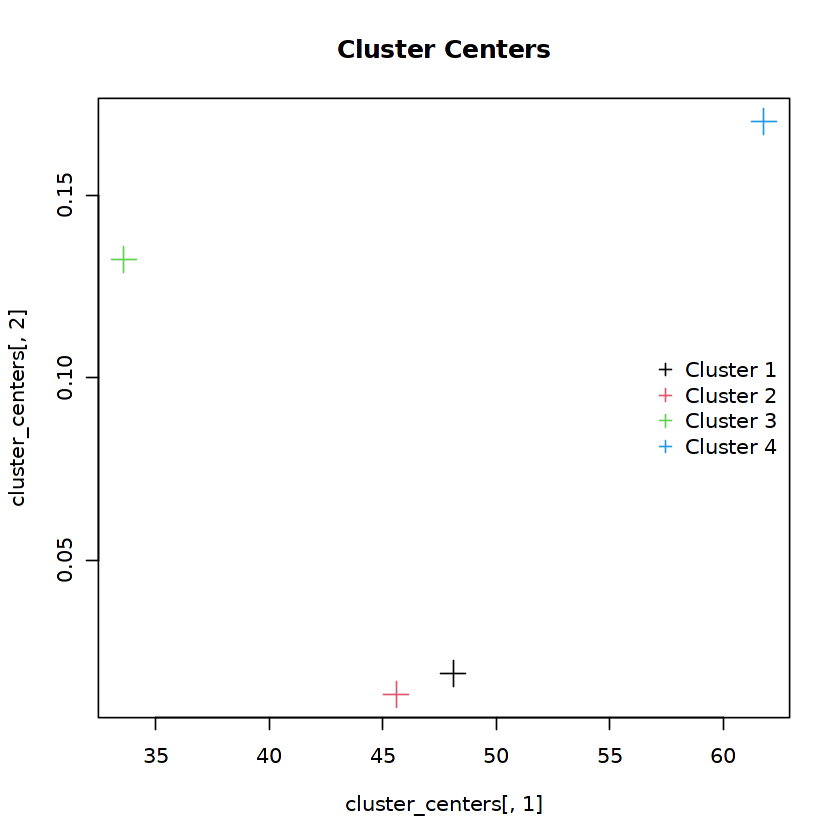

In [77]:
# Define a function to visualize only cluster centers
visualize_cluster_centers <- function(cluster_centers, xlab, ylab) {
  # Create a scatter plot for cluster centers
  plot(cluster_centers[, 1], cluster_centers[, 2], col = 1:nrow(cluster_centers), 
       pch = 3, cex = 2, xlab = xlab, ylab = ylab, 
       main = "Cluster Centers")
  
  # Add legend for cluster centers
  legend("right", legend = paste("Cluster", 1:nrow(cluster_centers)), 
         col = 1:nrow(cluster_centers), pch = 3, bty = "n")
}

# Extract variable names from kmeans1 object
xlab <- names(kmeans1$cluster_centers)[1]
ylab <- names(kmeans1$cluster_centers)[2]

# Visualize only cluster centers for df_KMeans1 with variable names from clustering result
visualize_cluster_centers(kmeans1$cluster_centers, xlab, ylab)

<h4>kmeans2 cluster center visualization</h4>

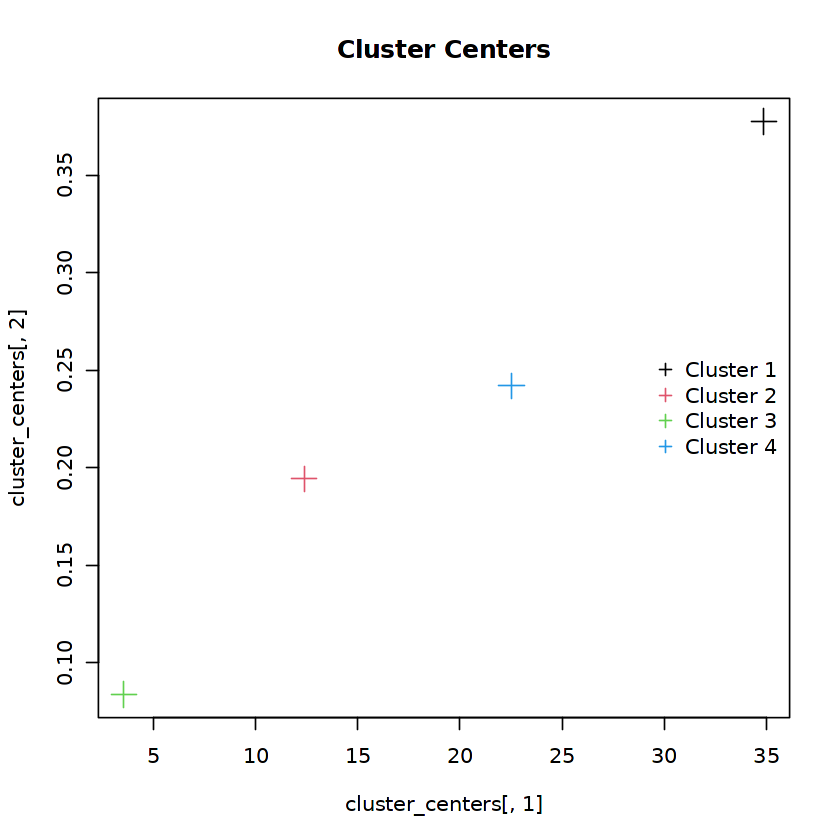

In [26]:
# Define a function to visualize only cluster centers
visualize_cluster_centers <- function(cluster_centers, xlab, ylab) {
  # Create a scatter plot for cluster centers
  plot(cluster_centers[, 1], cluster_centers[, 2], col = 1:nrow(cluster_centers), 
       pch = 3, cex = 2, xlab = xlab, ylab = ylab, 
       main = "Cluster Centers")
  
  # Add legend for cluster centers
  legend("right", legend = paste("Cluster", 1:nrow(cluster_centers)), 
         col = 1:nrow(cluster_centers), pch = 3, bty = "n")
}

# Extract variable names from kmeans1 object
xlab <- names(kmeans2$cluster_centers)[1]
ylab <- names(kmeans2$cluster_centers)[2]

# Visualize only cluster centers for df_KMeans2 with variable names from clustering result
visualize_cluster_centers(kmeans2$cluster_centers, xlab, ylab)

<h4>kmeans3 cluster center visualization</h4>

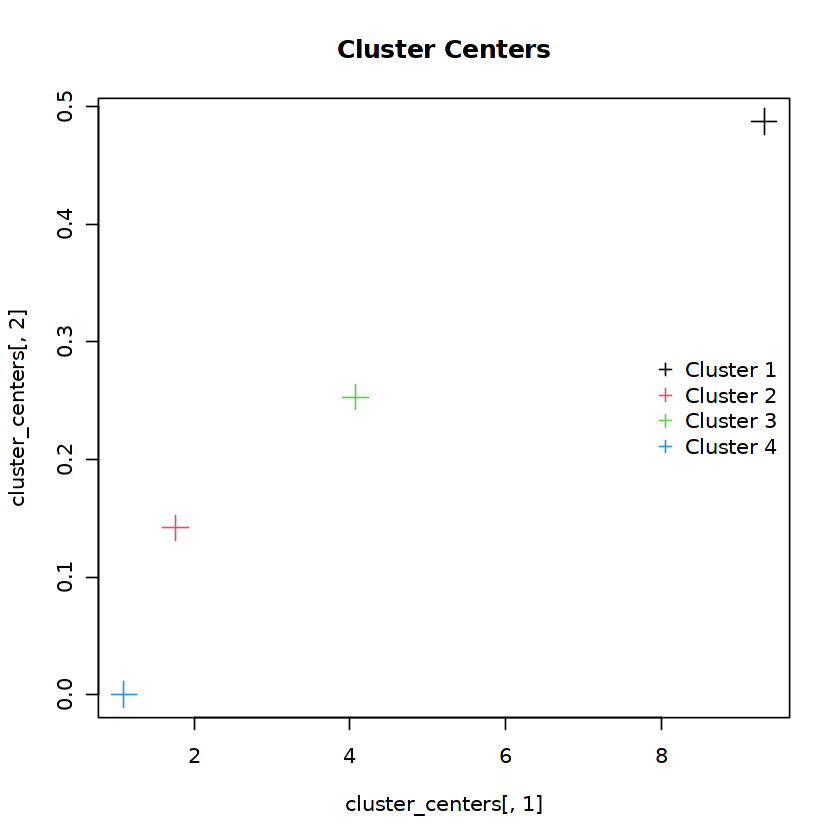

In [27]:
# Define a function to visualize only cluster centers
visualize_cluster_centers <- function(cluster_centers, xlab, ylab) {
  # Create a scatter plot for cluster centers
  plot(cluster_centers[, 1], cluster_centers[, 2], col = 1:nrow(cluster_centers), 
       pch = 3, cex = 2, xlab = xlab, ylab = ylab, 
       main = "Cluster Centers")
  
  # Add legend for cluster centers
  legend("right", legend = paste("Cluster", 1:nrow(cluster_centers)), 
         col = 1:nrow(cluster_centers), pch = 3, bty = "n")
}

# Extract variable names from kmeans1 object
xlab <- names(kmeans3$cluster_centers)[1]
ylab <- names(kmeans3$cluster_centers)[2]

# Visualize only cluster centers for df_KMeans3 with variable names from clustering result
visualize_cluster_centers(kmeans3$cluster_centers, xlab, ylab)

<h4>kmeans4 cluster center visualization</h4>

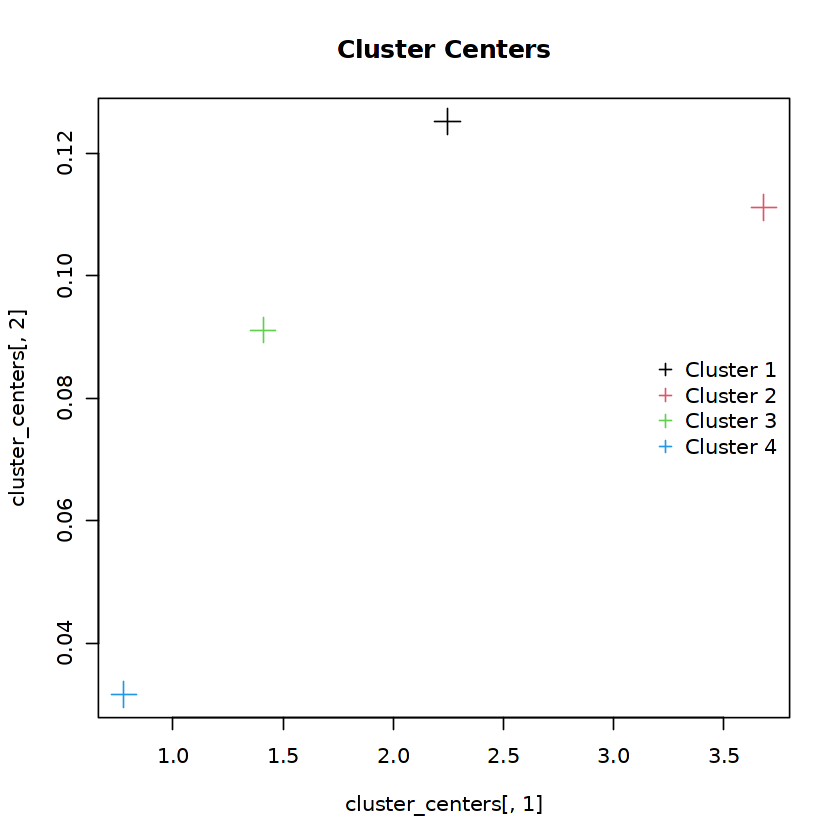

In [28]:
# Define a function to visualize only cluster centers
visualize_cluster_centers <- function(cluster_centers, xlab, ylab) {
  # Create a scatter plot for cluster centers
  plot(cluster_centers[, 1], cluster_centers[, 2], col = 1:nrow(cluster_centers), 
       pch = 3, cex = 2, xlab = xlab, ylab = ylab, 
       main = "Cluster Centers")
  
  # Add legend for cluster centers
  legend("right", legend = paste("Cluster", 1:nrow(cluster_centers)), 
         col = 1:nrow(cluster_centers), pch = 3, bty = "n")
}

# Extract variable names from kmeans1 object
xlab <- names(kmeans4$cluster_centers)[1]
ylab <- names(kmeans4$cluster_centers)[2]

# Visualize only cluster centers for df_KMeans4 with variable names from clustering result
visualize_cluster_centers(kmeans4$cluster_centers, xlab, ylab)

<h4>Summary</h4>
<p>By plotting the cluster centers we can visually assess the separation between clusters <br/> 
and evaluate the effectiveness of the clustering algorithm in partitioning the data into distinct groups.</p>

<h3>Generate Cluster Profiles</h3>
<span><strong>Note:</strong> The `data` parameter in the cluster_profile() function represents the original dataset (i.e. df_KMeans1, df_KMeans2, ...) from which the cluster profiles are generated.</span>

In [29]:
# Define a function to generate cluster profiles
cluster_profile <- function(data, cluster_assignments) {
  # Combine data with cluster assignments
  data$cluster <- cluster_assignments
  
  # Compute summary statistics for each cluster
  cluster_summary <- aggregate(. ~ cluster, data, function(x) c(mean = mean(x), sd = sd(x)))
  
  # Return cluster profile
  return(cluster_summary)
}

# Generate cluster profiles for each dataframe
cluster_profile1 <- cluster_profile(df_KMeans1, kmeans1$cluster_assignments)
cluster_profile2 <- cluster_profile(df_KMeans2, kmeans2$cluster_assignments)
cluster_profile3 <- cluster_profile(df_KMeans3, kmeans3$cluster_assignments)
cluster_profile4 <- cluster_profile(df_KMeans4, kmeans4$cluster_assignments)

# Combine cluster profiles into a single list
all_cluster_profiles <- list(cluster_profile1, cluster_profile2, cluster_profile3, cluster_profile4)

# Print cluster profiles
for (i in 1:4) {
  cat("Cluster Profile for df_KMeans", i, ":\n")                               
  #print(summary(all_cluster_profiles[[i]]))
  cat("\n")
}

Cluster Profile for df_KMeans 1 :

Cluster Profile for df_KMeans 2 :

Cluster Profile for df_KMeans 3 :

Cluster Profile for df_KMeans 4 :



<h4>Summary</h4>
<p>We generate cluster profiles which can be used in developing segmentation strategy either by identifying unique needs or different behaviors of customer segments.</p>

<h3>Visualize the Cluster Profiles</h3>
<p>Using the mean and standard deviation vectors for each variables</p>

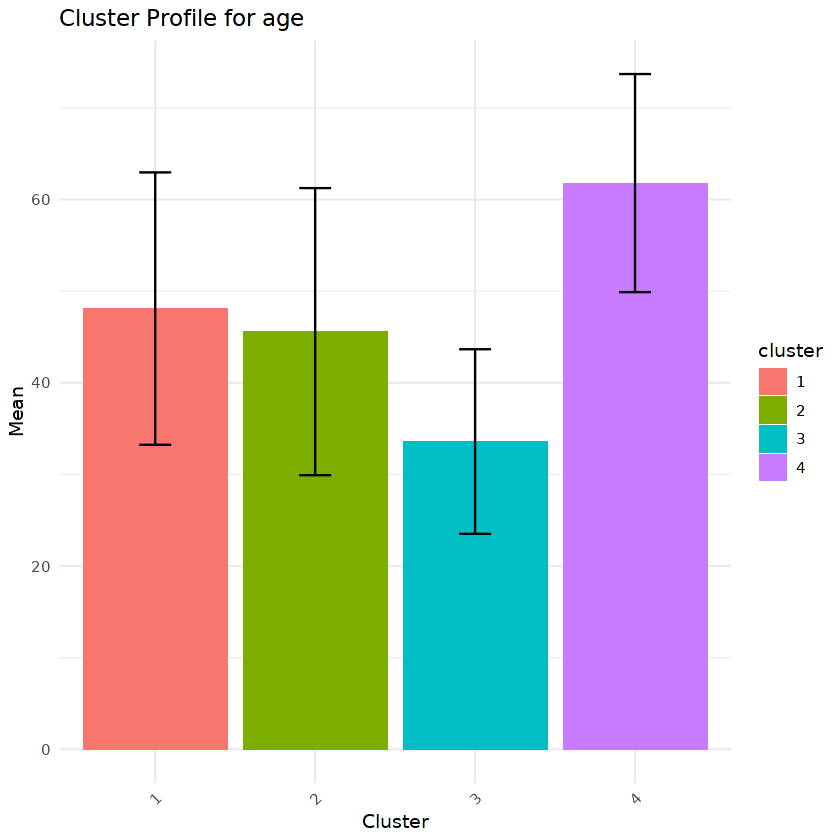

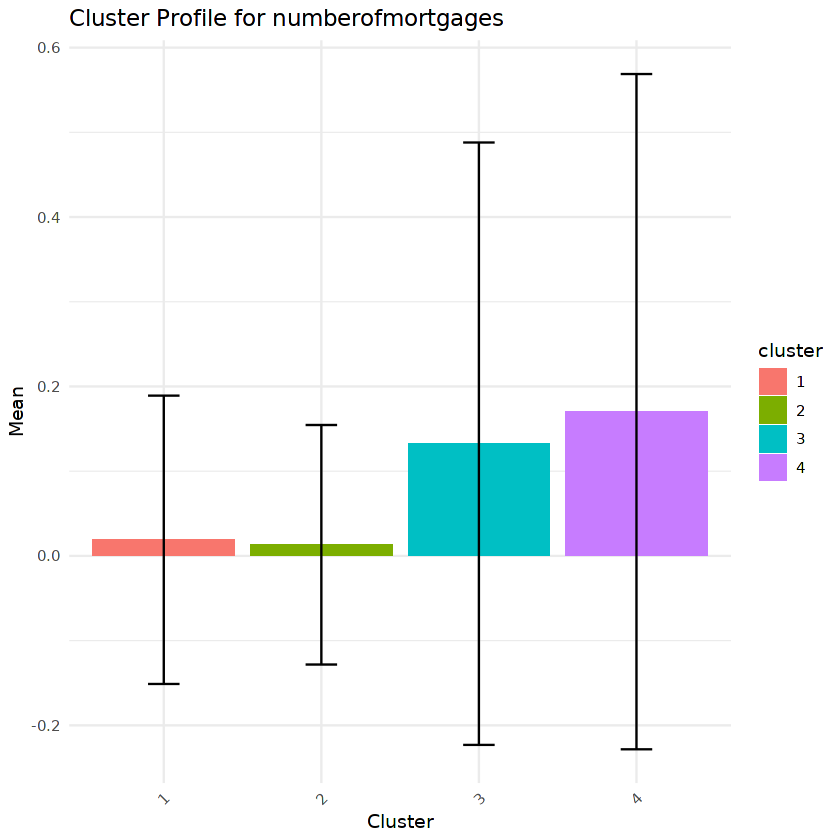

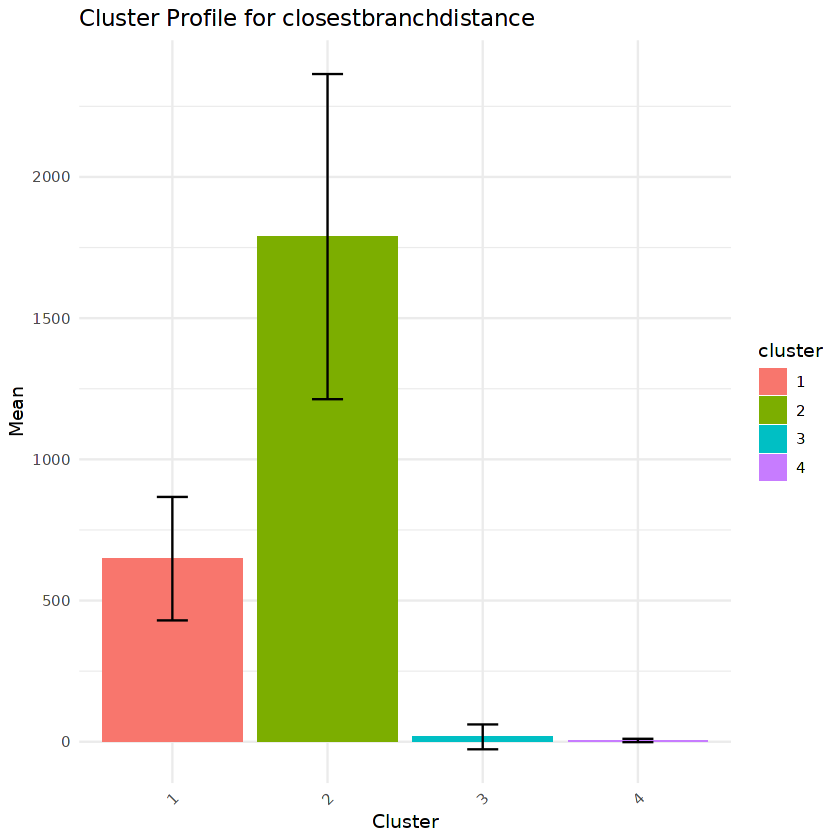

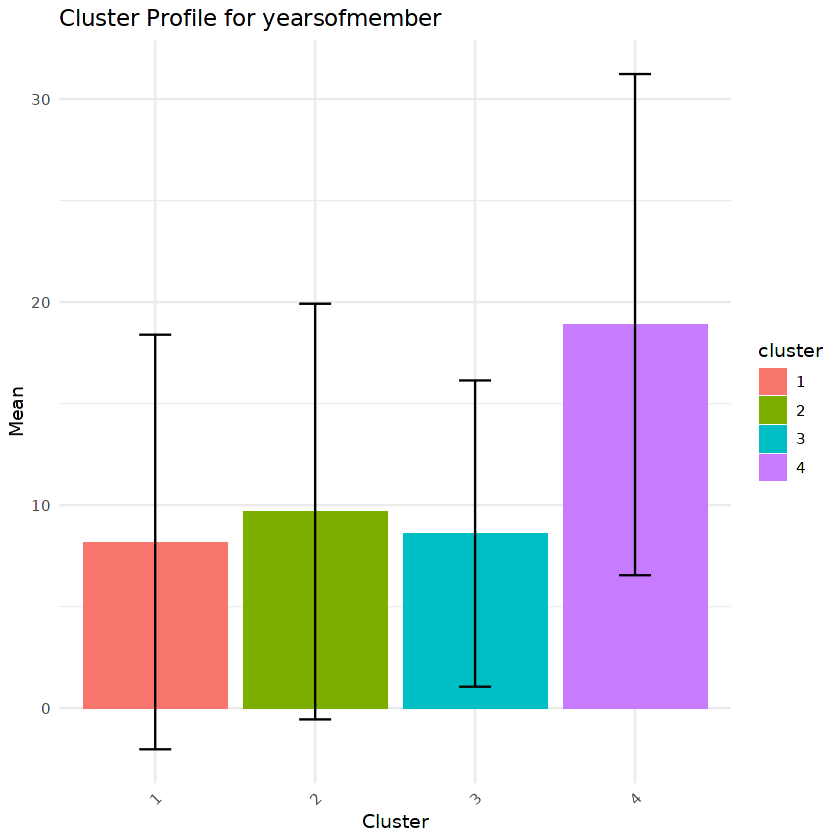

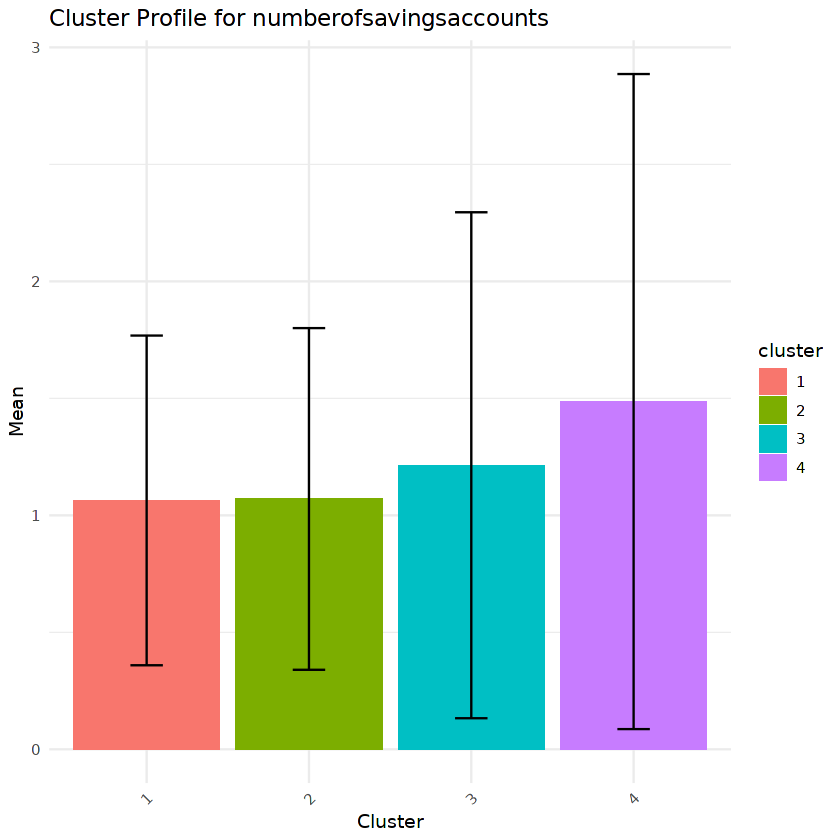

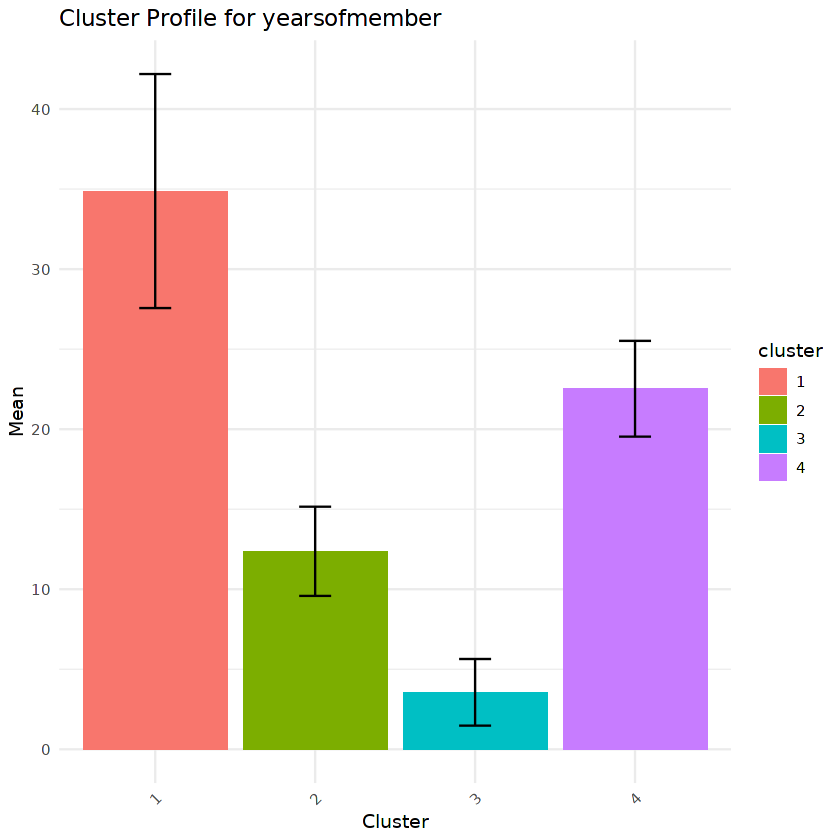

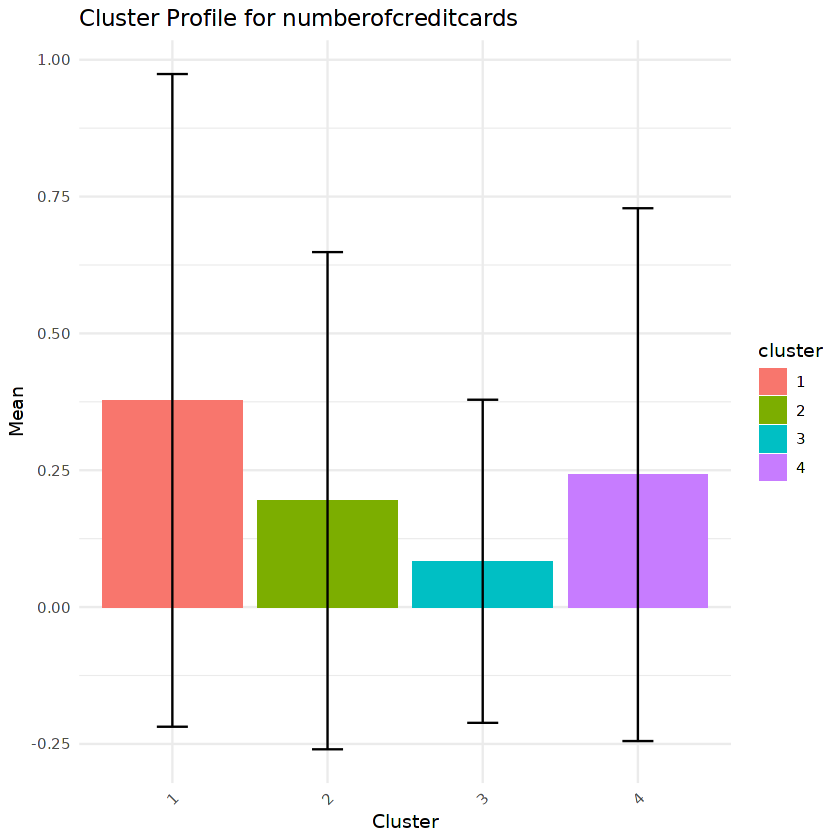

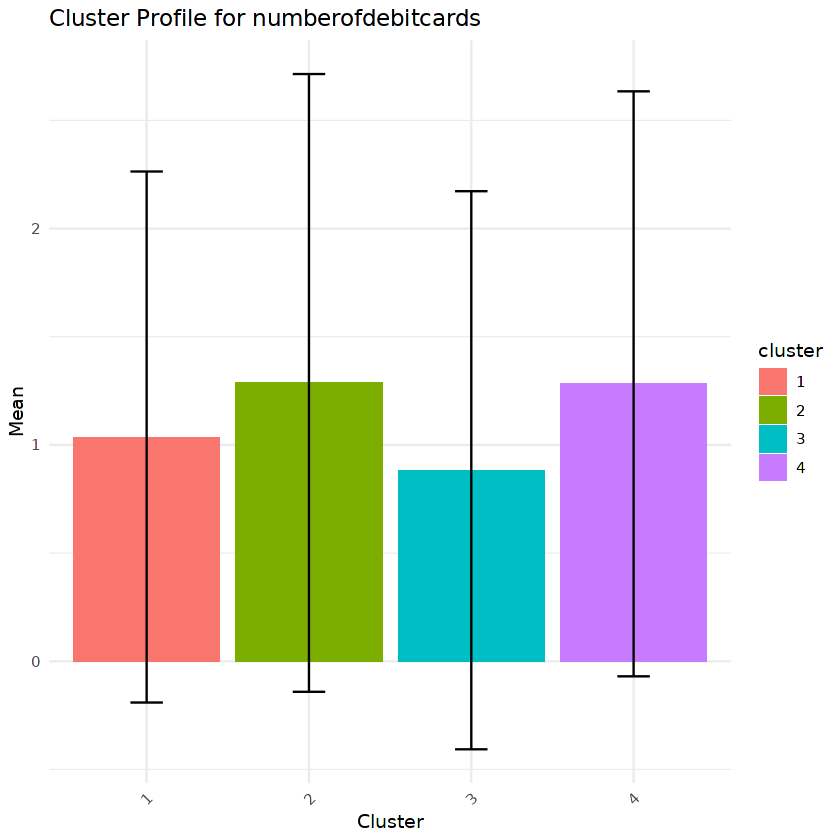

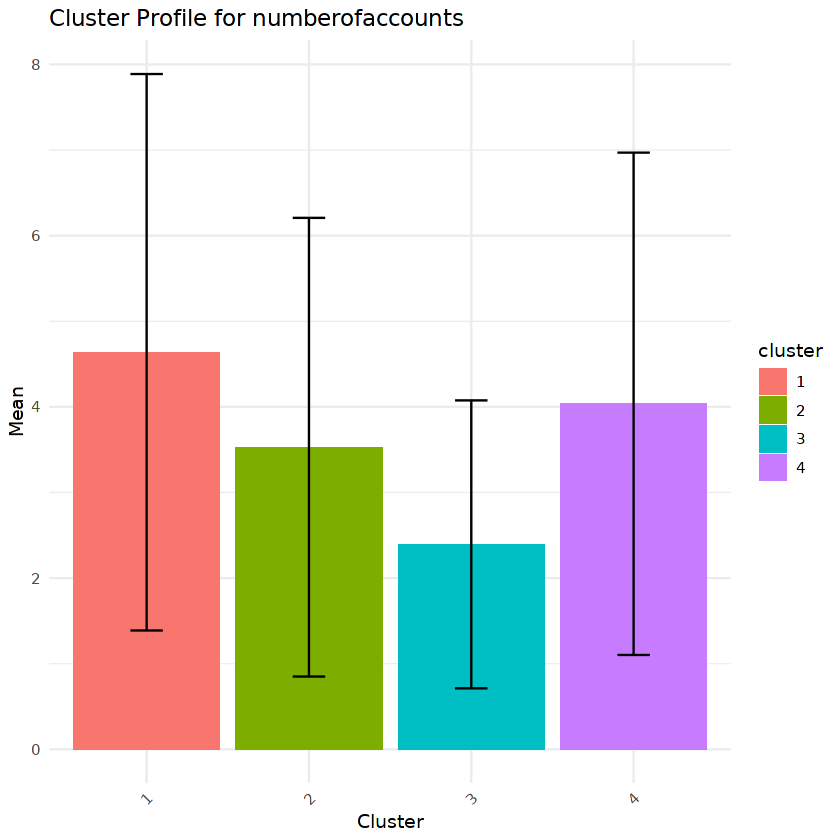

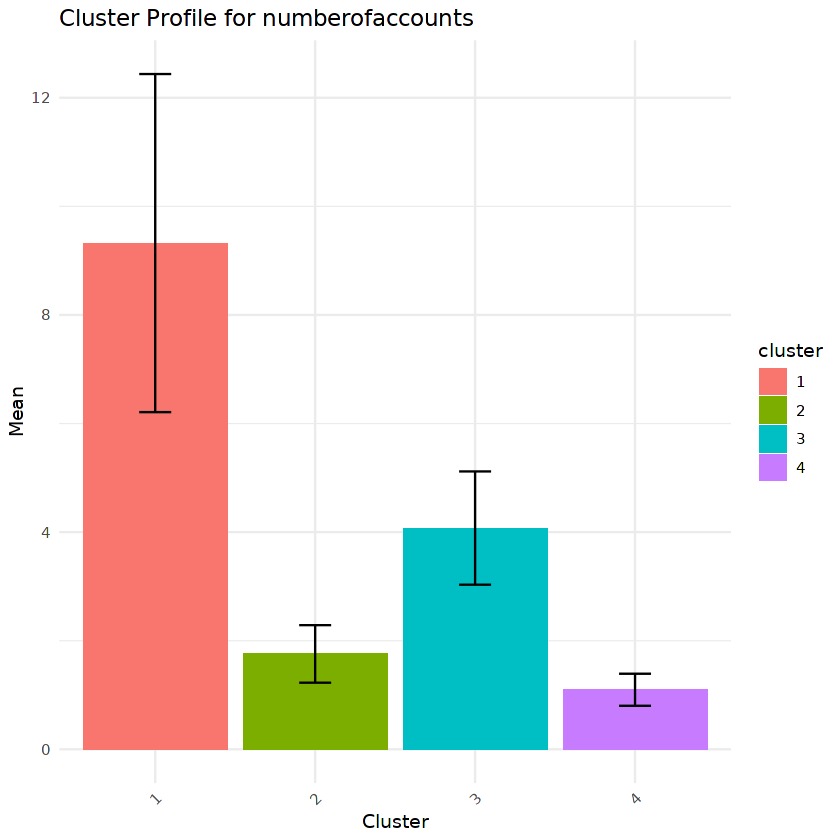

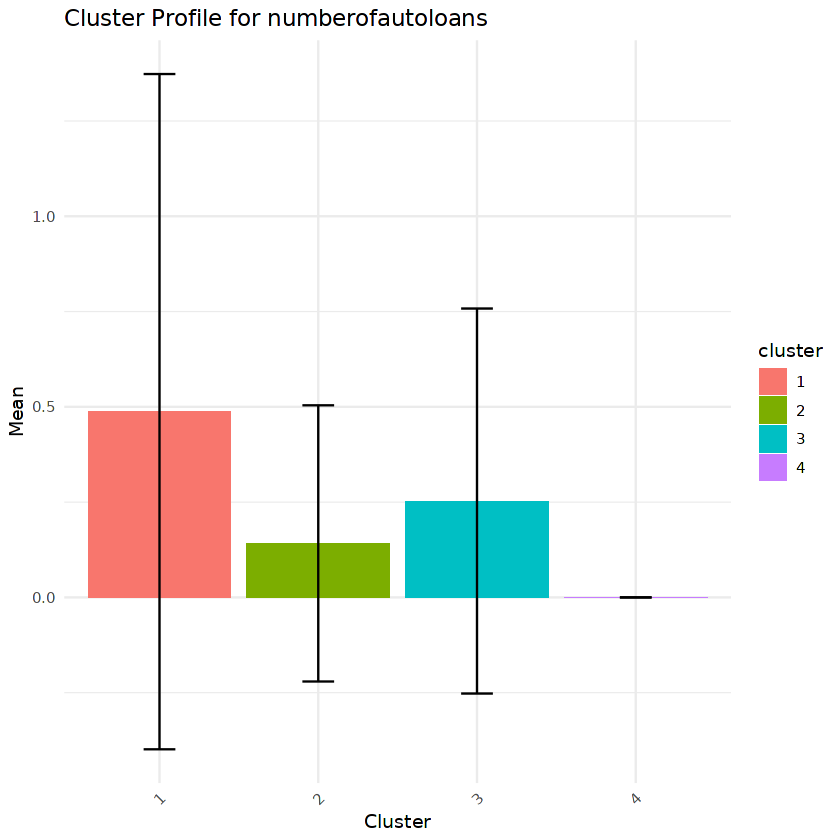

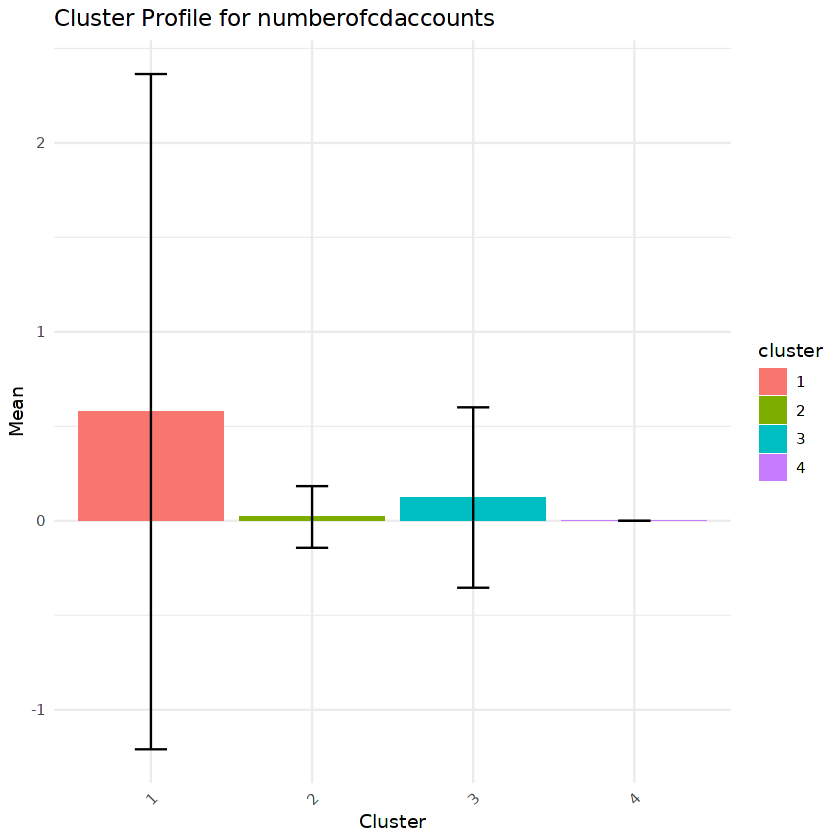

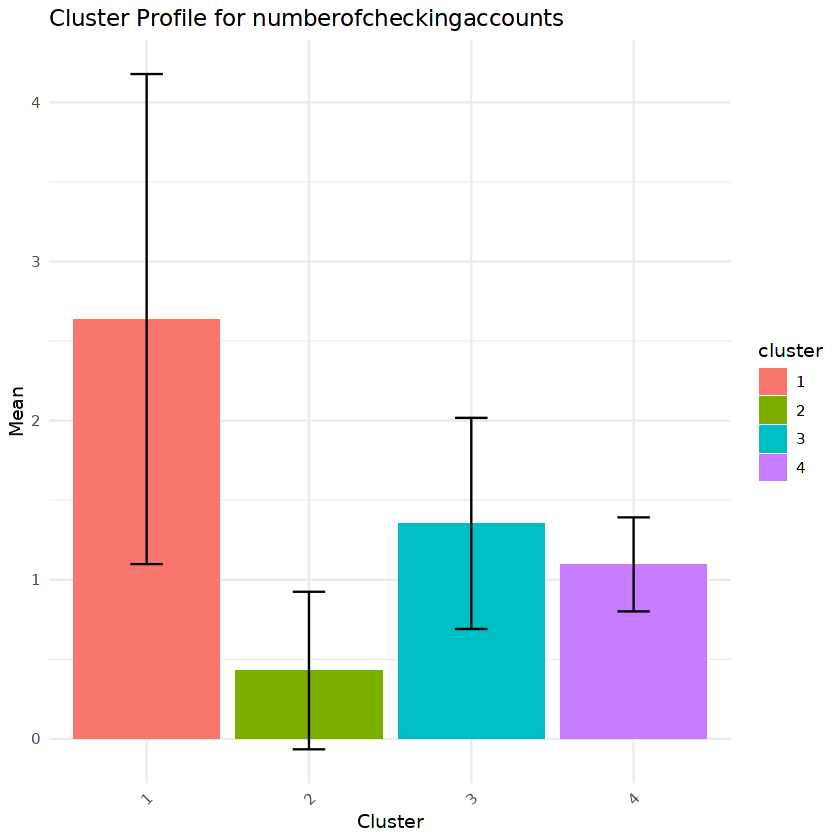

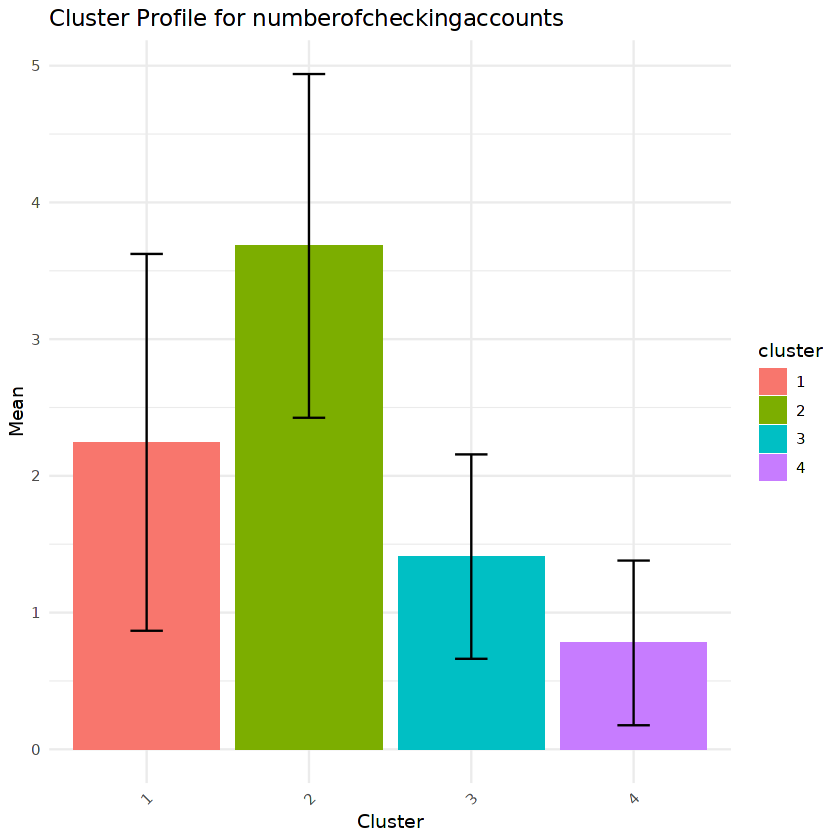

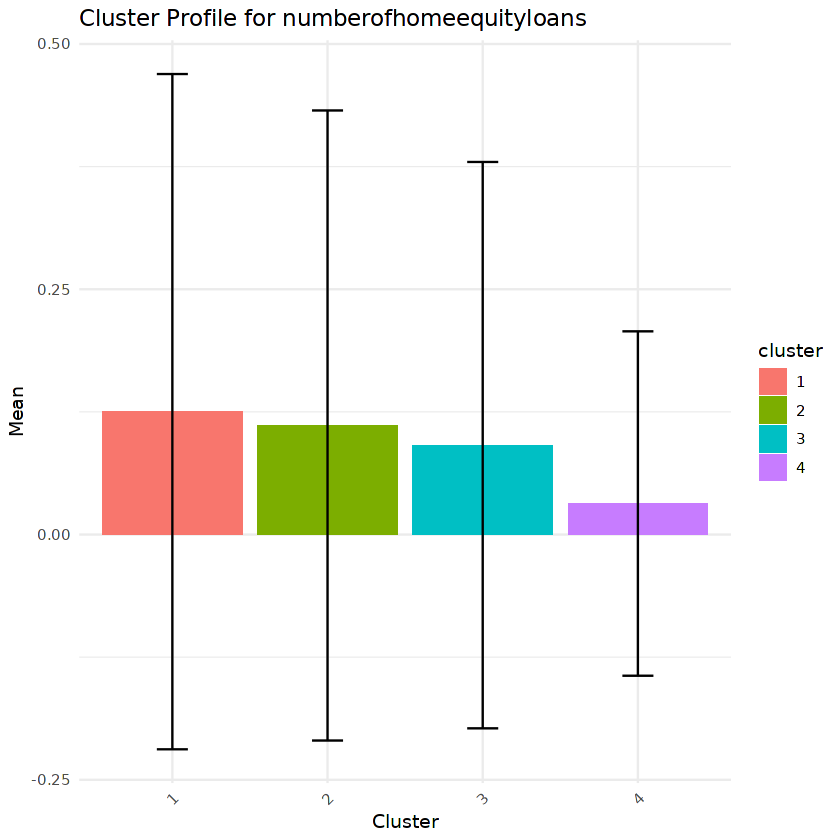

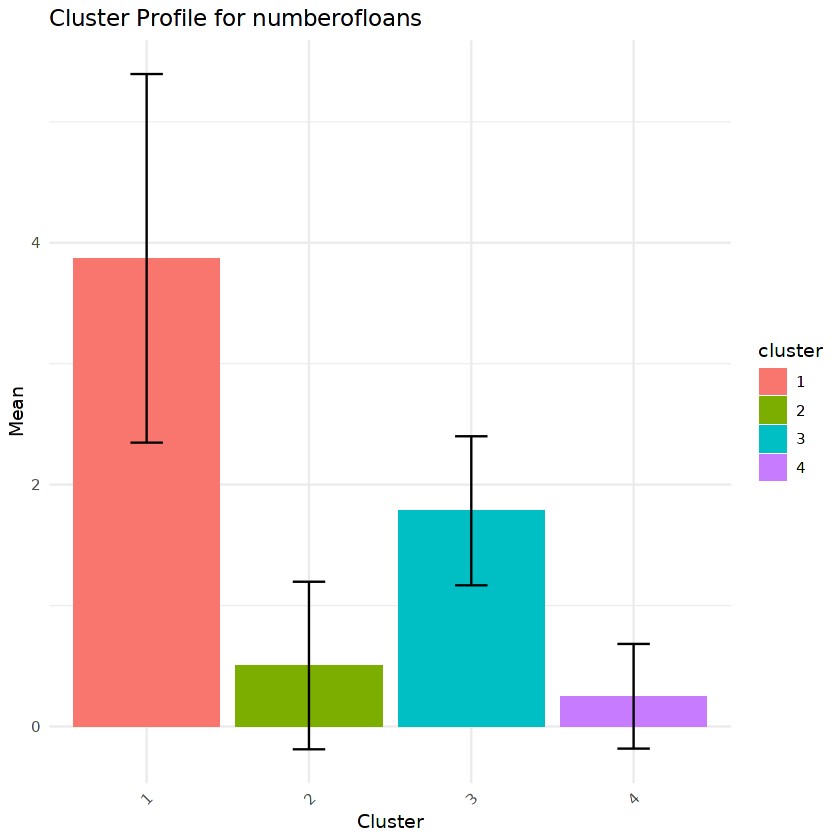

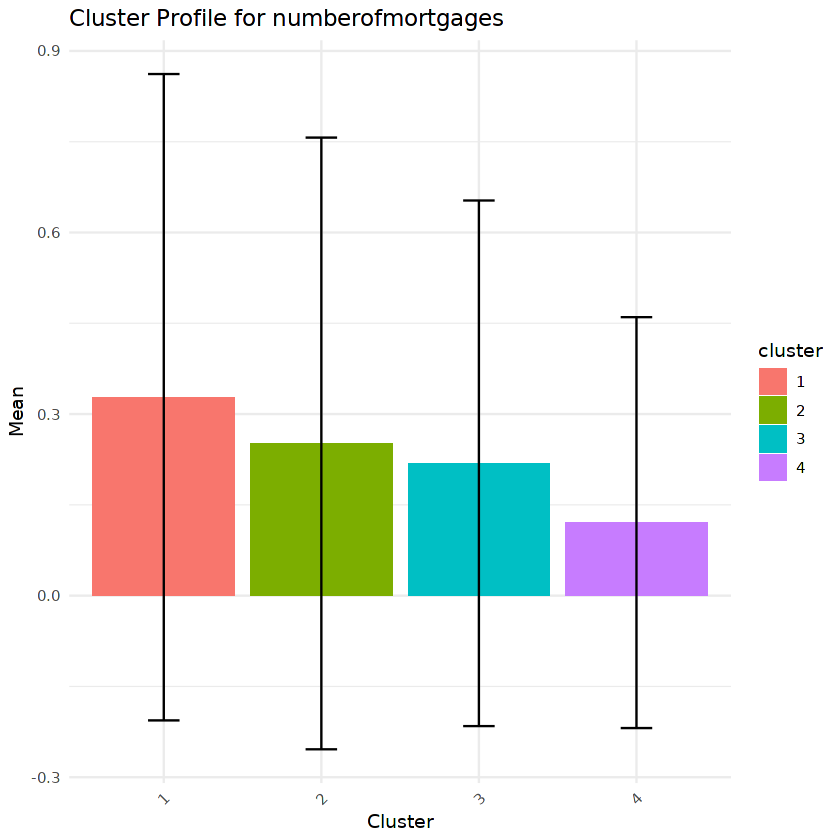

In [30]:
# Define a function to plot cluster profiles
plot_cluster_profiles <- function(cluster_profiles) {
  for (i in seq_along(cluster_profiles)) {
    cluster_profile <- cluster_profiles[[i]]
    
    # Create a bar plot for each cluster
    for (j in 2:ncol(cluster_profile)) { # Skip the first column (cluster)
      variable_name <- names(cluster_profile)[j]
      
      # Extract mean and standard deviation vectors for the variable
      means <- cluster_profile[[j]][, "mean"]
      sds <- cluster_profile[[j]][, "sd"]
      
      # Create a data frame for plotting
      bar_data <- data.frame(cluster = factor(cluster_profile$cluster),
                             mean = means,
                             sd = sds)
      
      # Plot the bar plot
      print(
        ggplot(bar_data, aes(x = cluster, y = mean, fill = cluster)) +
          geom_bar(stat = "identity") +
          geom_errorbar(aes(ymin = mean - sd, ymax = mean + sd), width = 0.2) +
          labs(title = paste("Cluster Profile for", variable_name),
               x = "Cluster", y = "Mean") +
          theme_minimal() +
          theme(axis.text.x = element_text(angle = 45, hjust = 1))
      )
    }
  }
}

# Call the function to plot cluster profiles
plot_cluster_profiles(all_cluster_profiles)

<h4>Summary</h4>
<p>We skip the first column (cluster) because it contains the cluster labels, which we use to differentiate the bars in the plot.</p> 
<p>We are interested in plotting the mean and standard deviation of each variable across different clusters, so we iterate over columns 2 to the last column of the cluster_profile data frame.</p> 
<p>These columns represent the variables we are interested in analyzing.</p>

<h3>Pairwise Combination of Features Colored by Cluster Assignment</h3>

<h4>Explanation</h4>
<p>We perform this analysis in order recognize patterns or associations between clusters that may not be evident when considering clusters individually.</p> 
<p>The thought is that this analysis will provide a more comprehensive understanding of the data structure.</p>

<h4>Pairwise feature combination for `kmeans1`</h4>

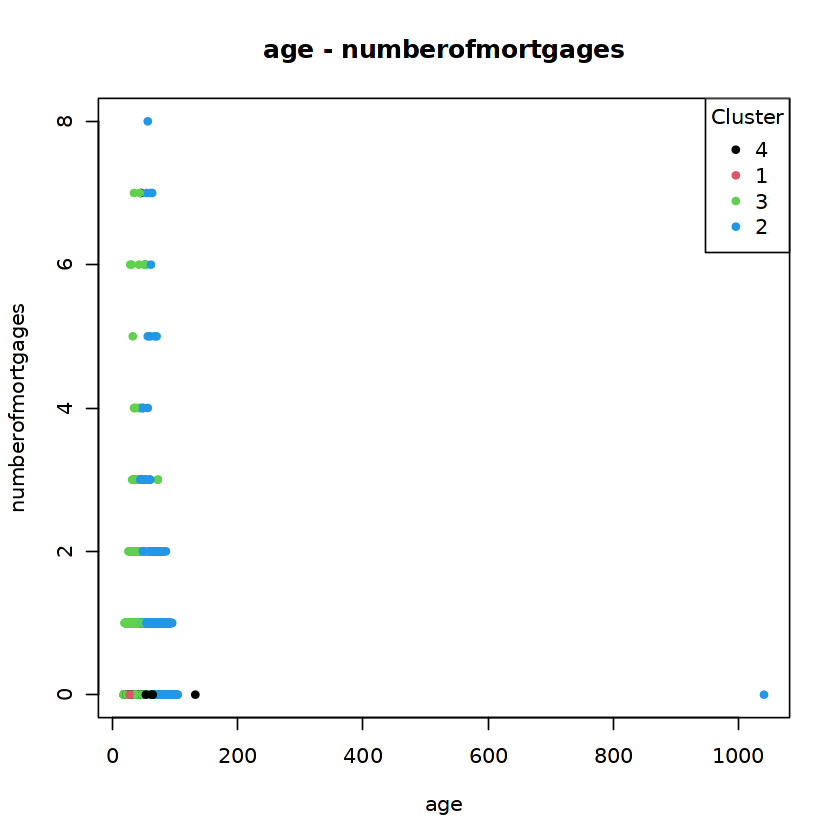

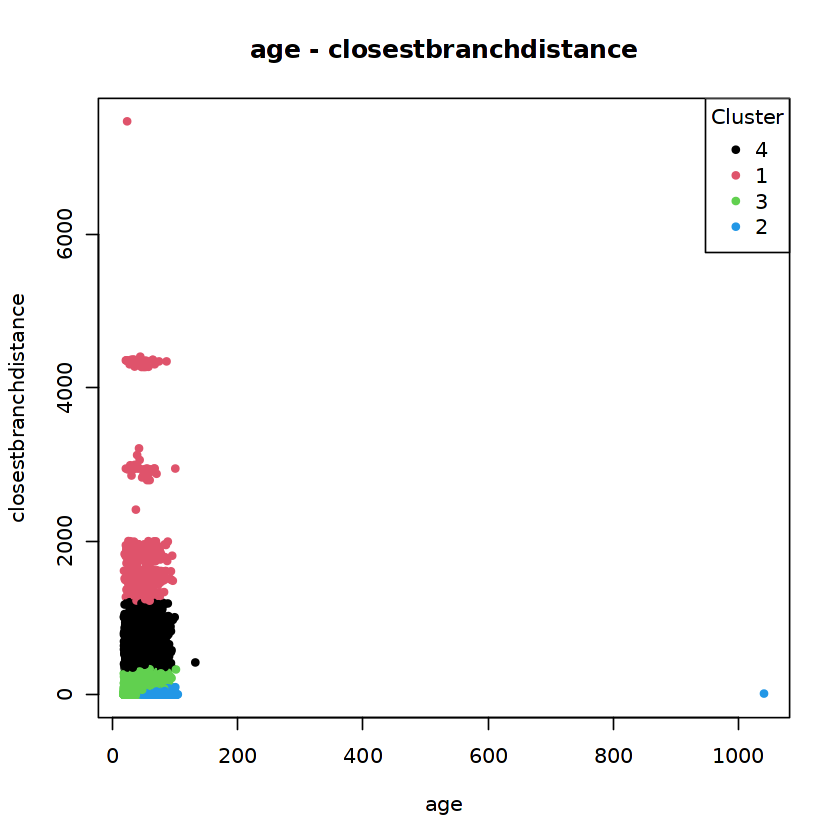

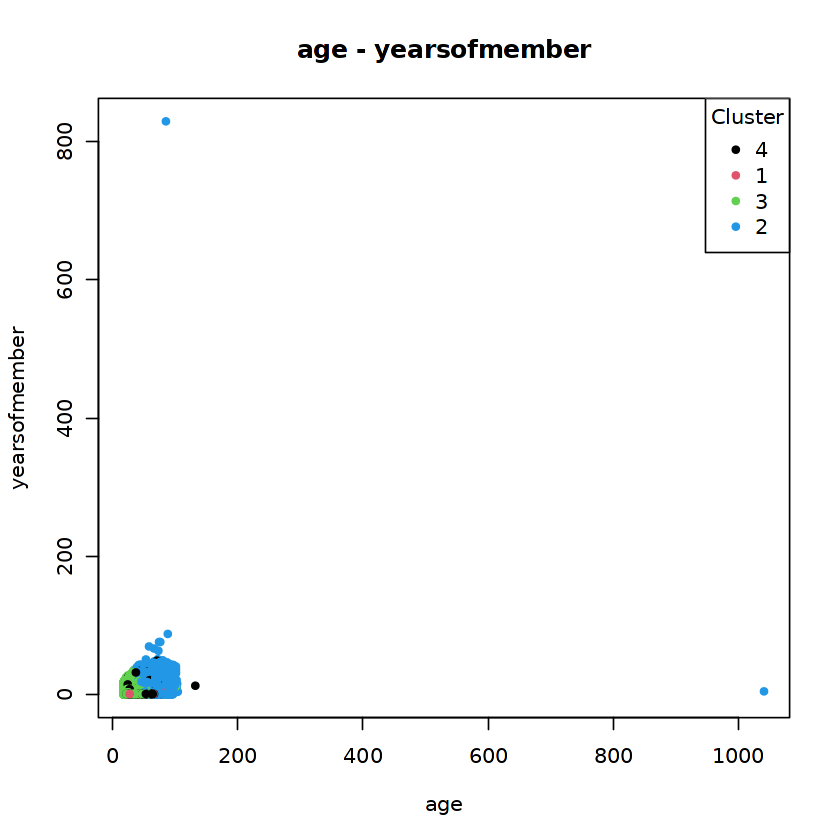

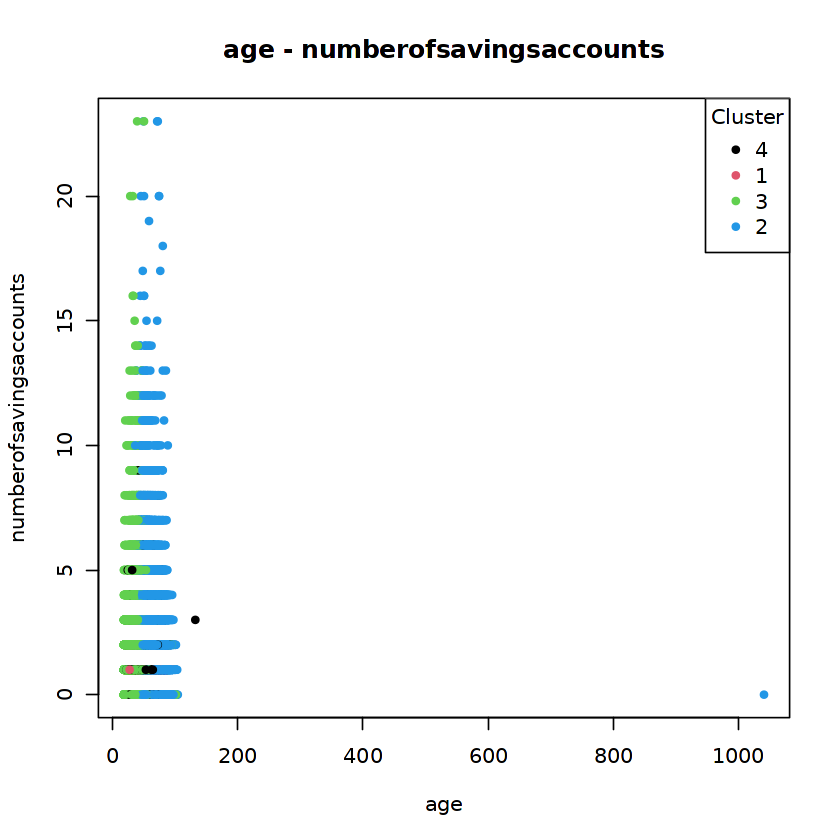

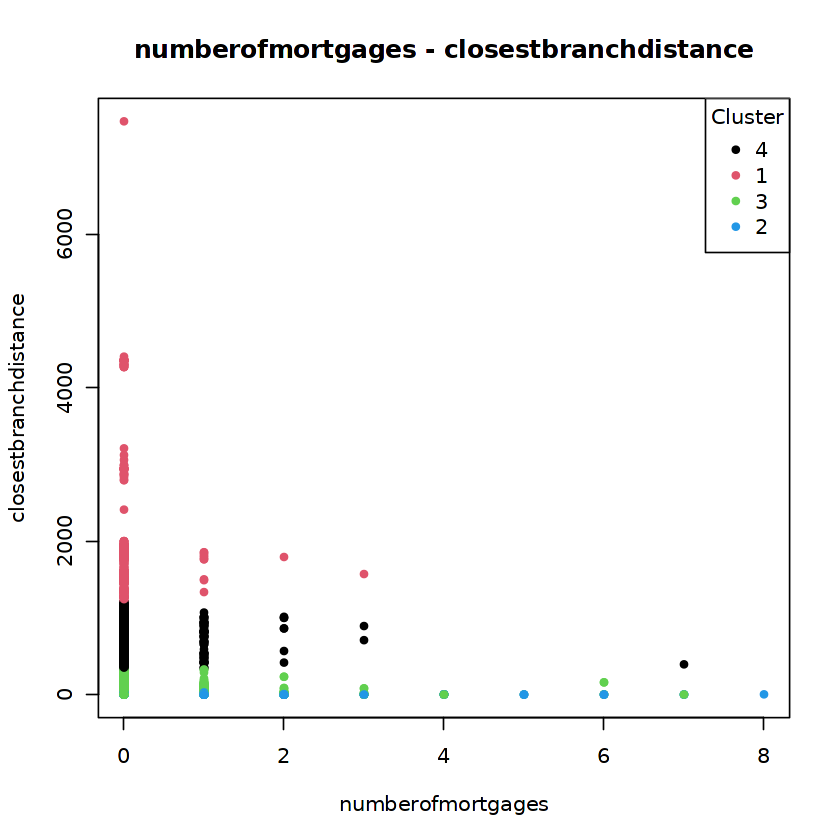

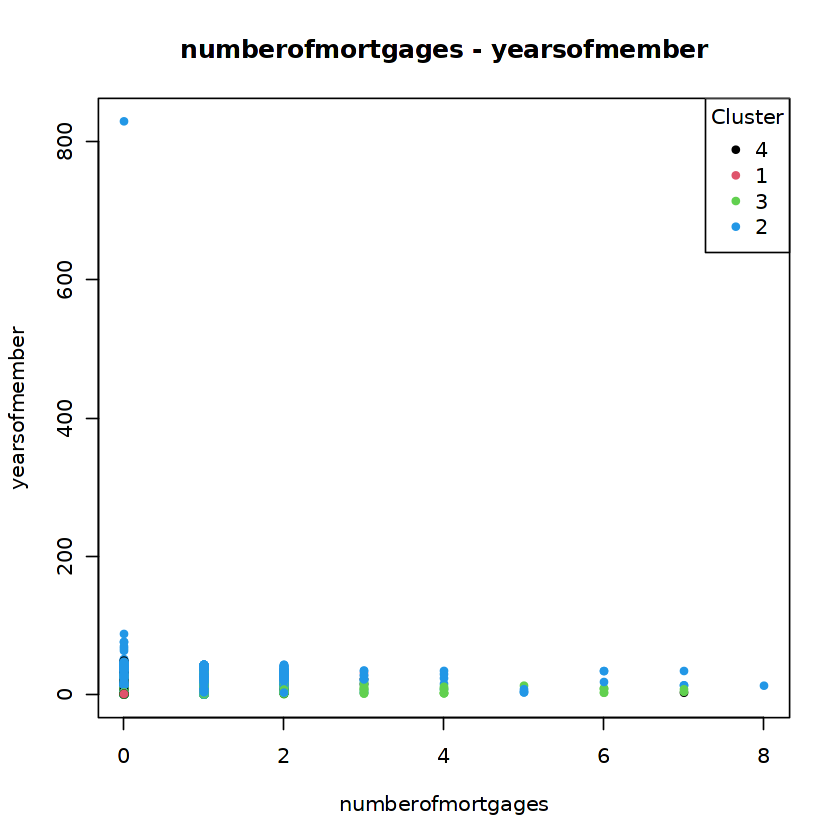

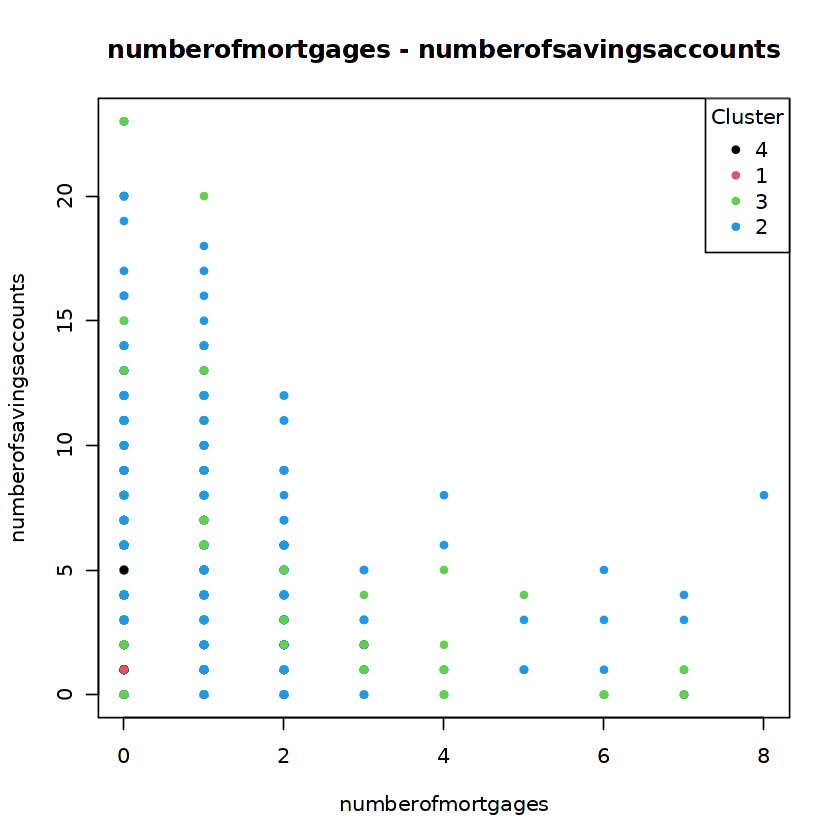

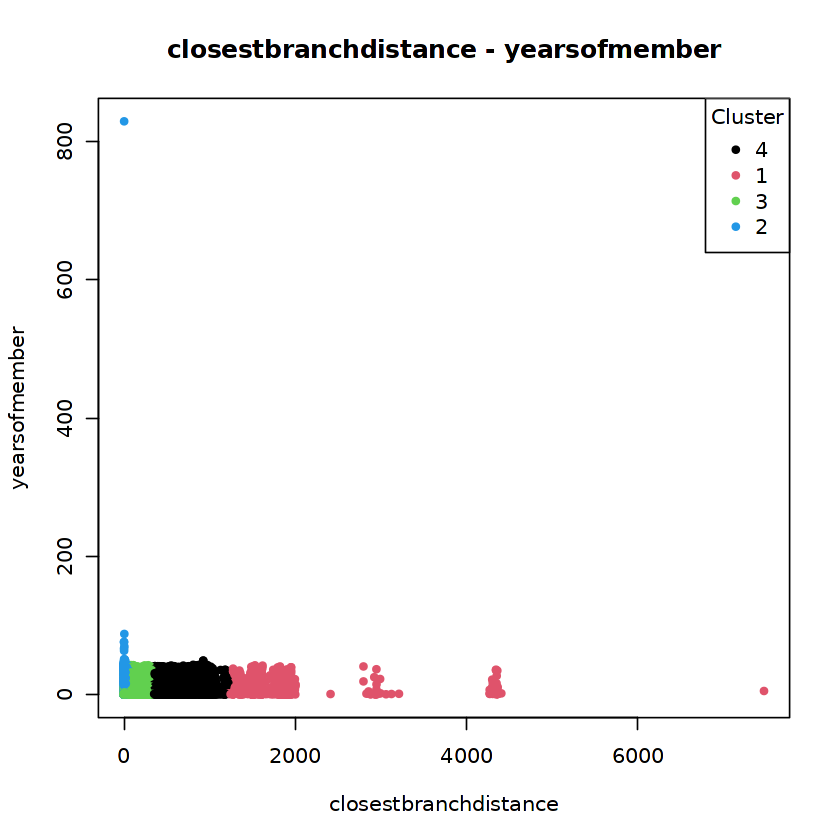

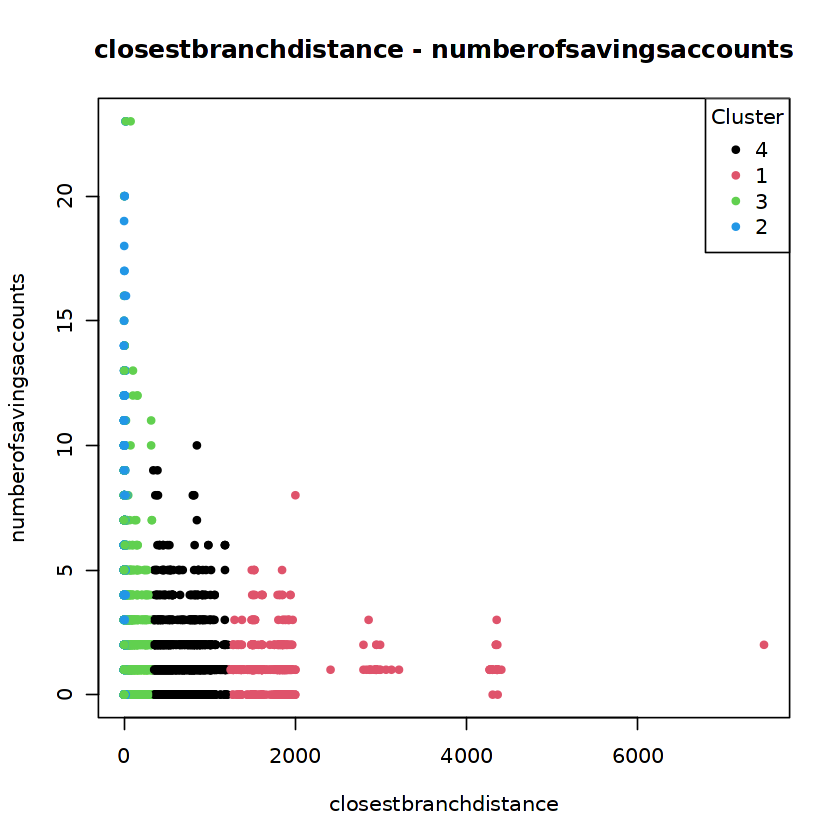

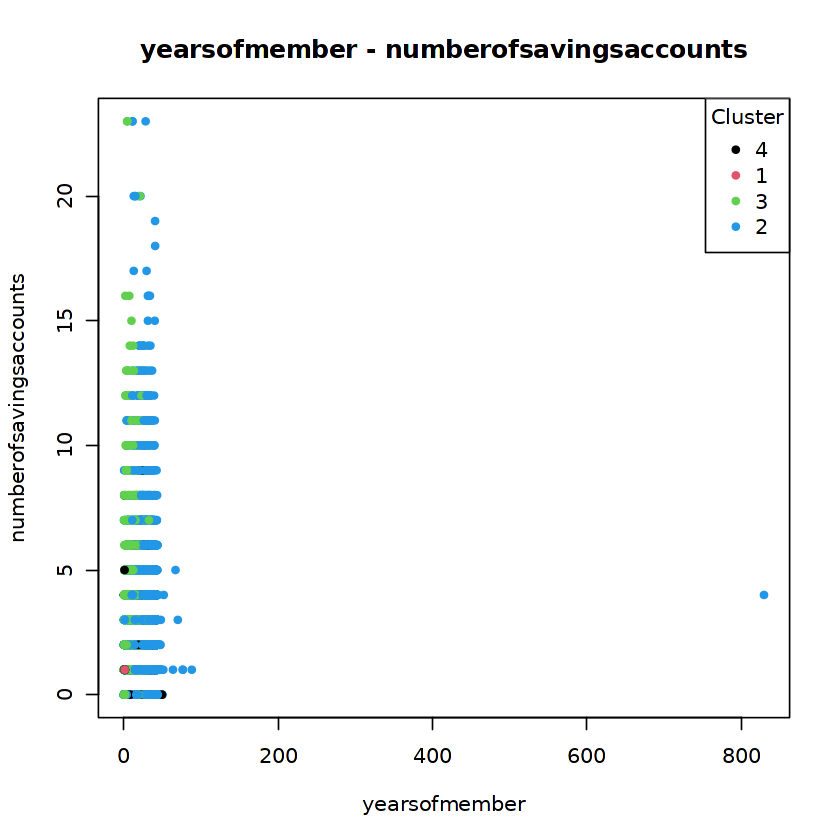

In [31]:
# Define a function to plot pairwise combinations of features
plot_pairwise_clusters <- function(df, cluster_assignments, title) {
  # Get unique cluster assignments
  clusters <- unique(cluster_assignments)
  
  # Set up the plot layout
  par(mfrow=c(1,1))
  
  # Iterate over pairwise combinations of features
  for (i in 1:(ncol(df) - 1)) {
    for (j in (i + 1):ncol(df)) {
      # Plot each pairwise combination
      plot(df[, i], df[, j], col = cluster_assignments, pch = 20,
           xlab = names(df)[i], ylab = names(df)[j], 
           main = paste(names(df)[i], "-", names(df)[j]))
      legend("topright", legend = clusters, col = 1:length(clusters), pch = 20, title = "Cluster")
    }
  }
}

# plot pairwise combinations of features colored by cluster assignment for kmeans1
plot_pairwise_clusters(df_KMeans1, kmeans1$cluster_assignments)

<h4>Pairwise feature combination of `kmeans2`</h4>

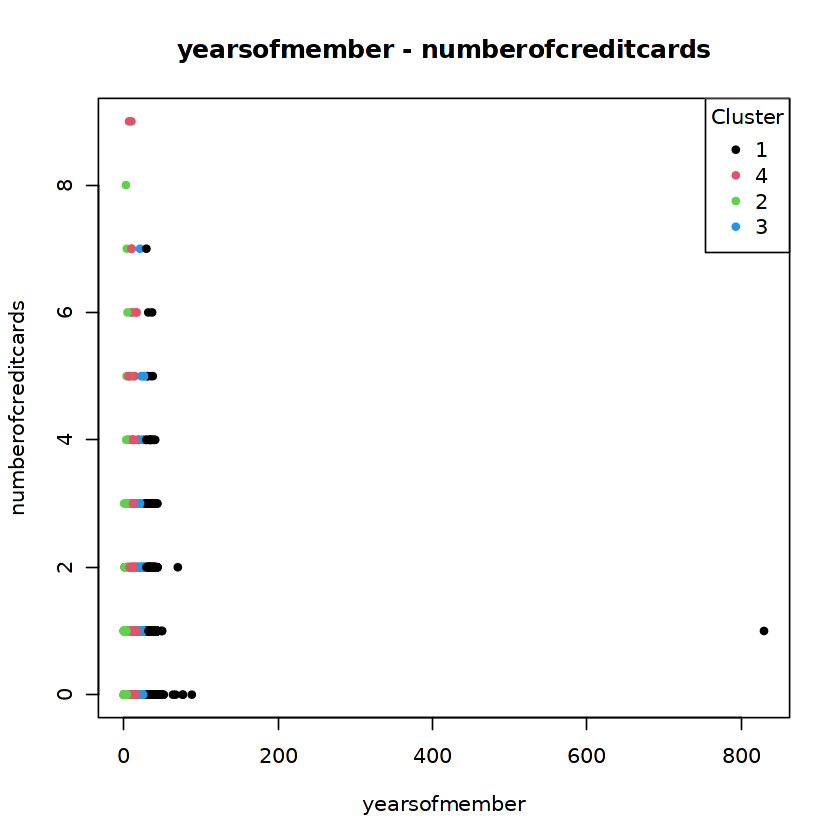

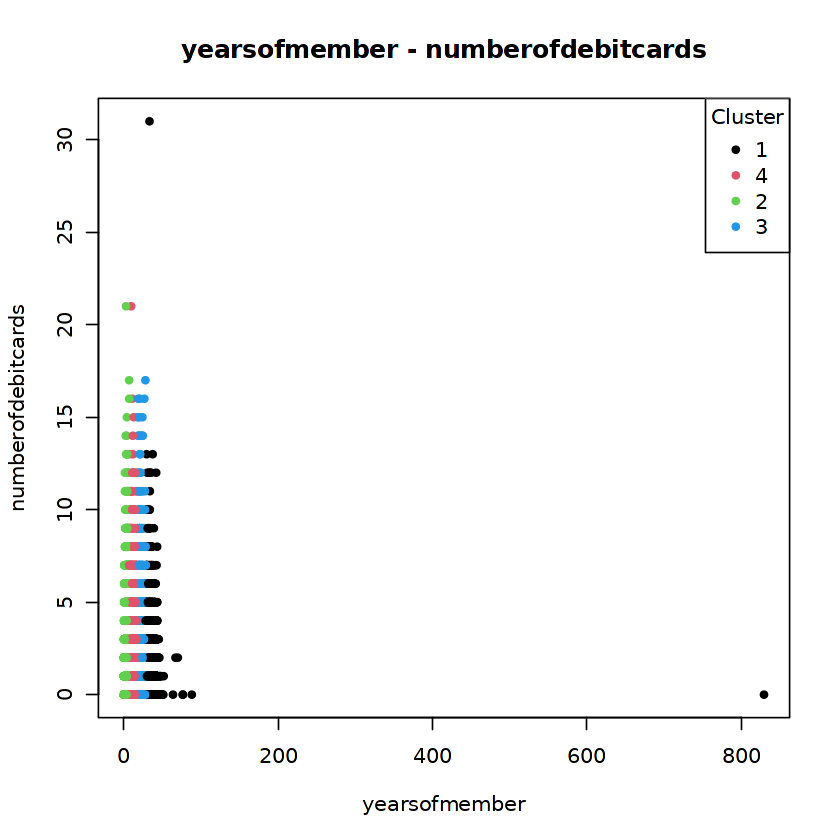

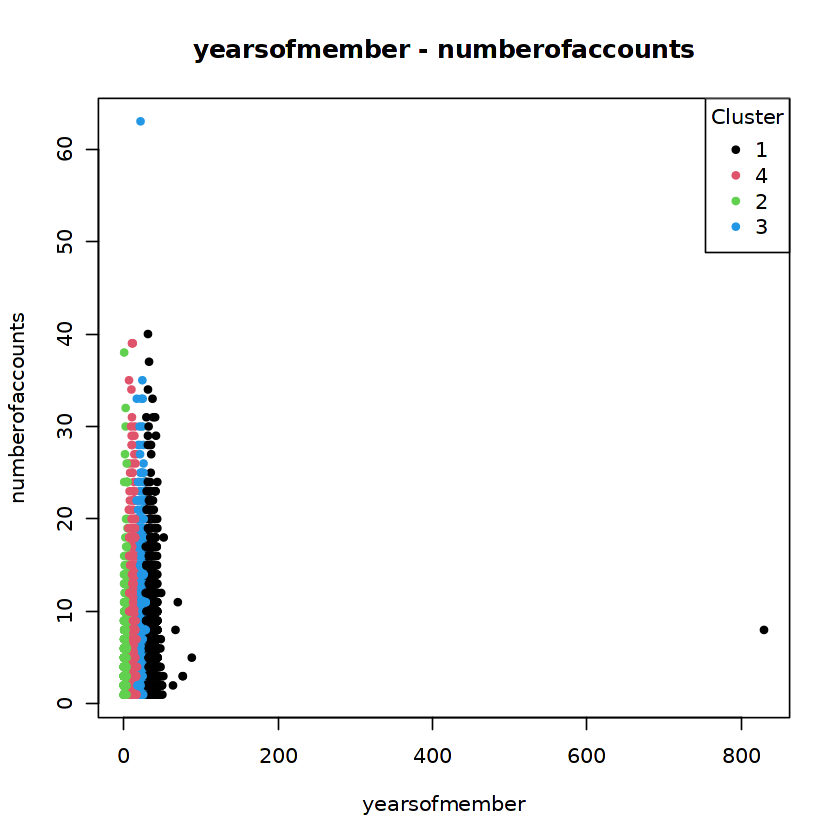

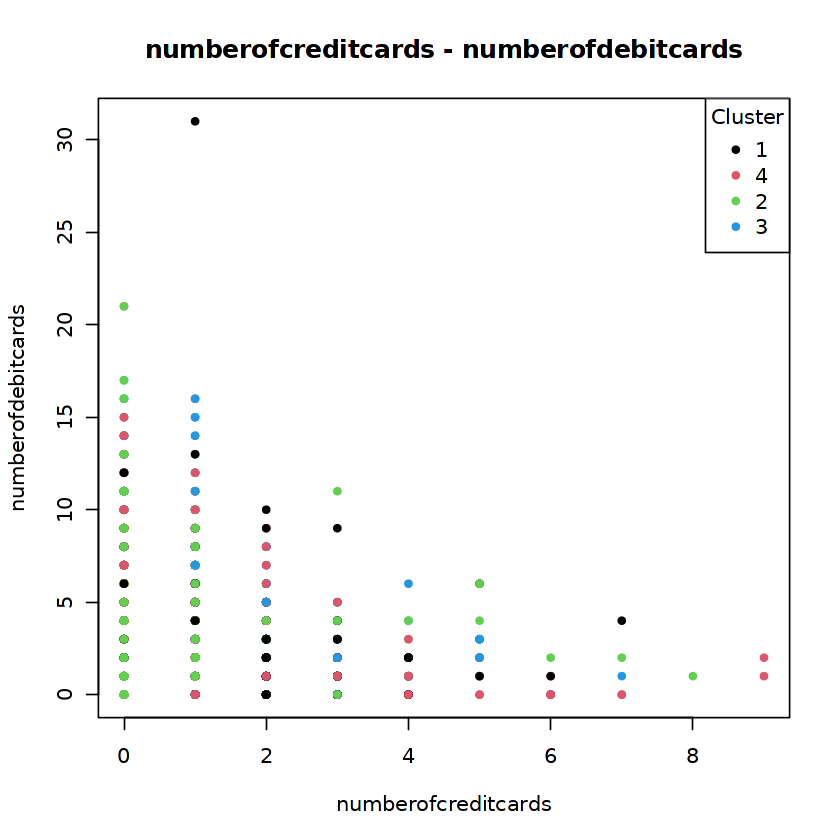

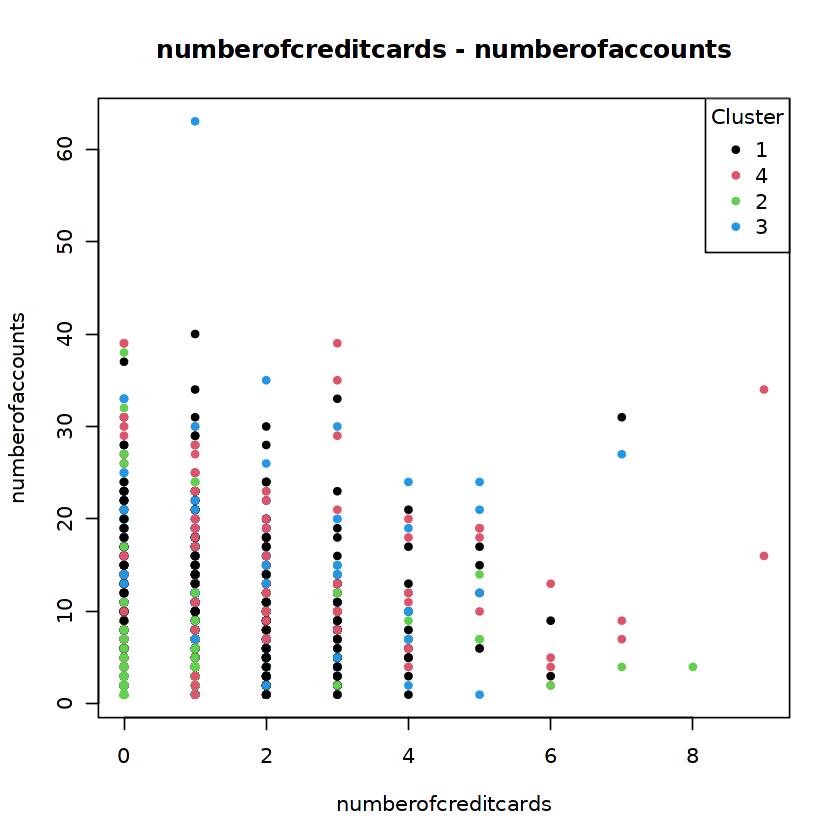

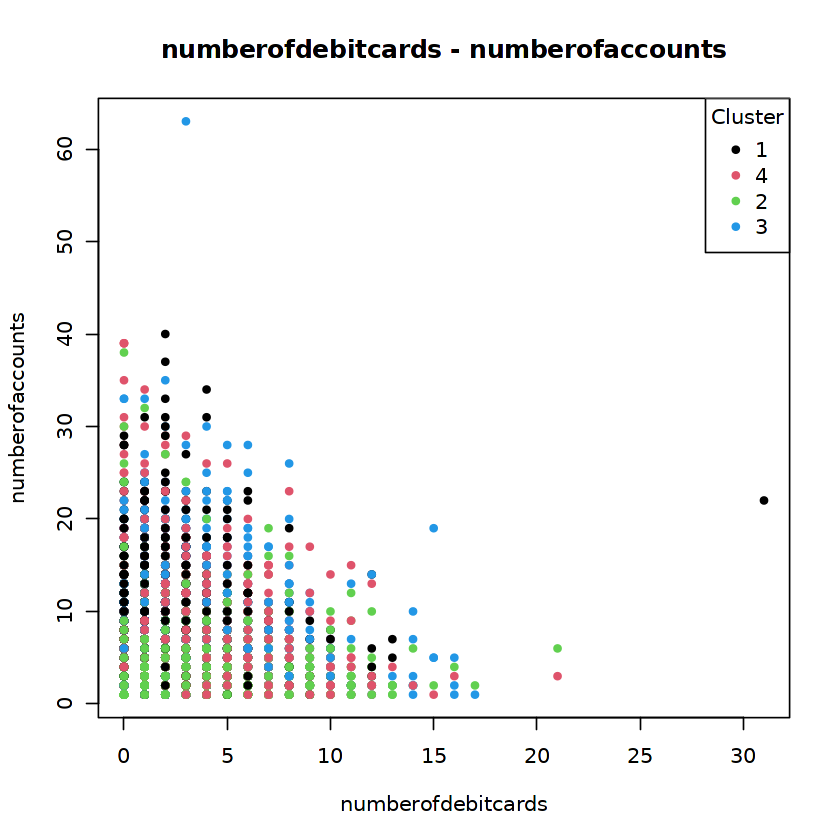

In [32]:
# Define a function to plot pairwise combinations of features
plot_pairwise_clusters <- function(df, cluster_assignments, title) {
  # Get unique cluster assignments
  clusters <- unique(cluster_assignments)
  
  # Set up the plot layout
  par(mfrow=c(1,1))
  
  # Iterate over pairwise combinations of features
  for (i in 1:(ncol(df) - 1)) {
    for (j in (i + 1):ncol(df)) {
      # Plot each pairwise combination
      plot(df[, i], df[, j], col = cluster_assignments, pch = 20,
           xlab = names(df)[i], ylab = names(df)[j], 
           main = paste(names(df)[i], "-", names(df)[j]))
      legend("topright", legend = clusters, col = 1:length(clusters), pch = 20, title = "Cluster")
    }
  }
}

# plot pairwise combinations of features colored by cluster assignment for kmeans2
plot_pairwise_clusters(df_KMeans2, kmeans2$cluster_assignments)

<h4>Summary</h4>
<p>We plot the pairwise combination of feature because we want to explore the relationship between different features within each cluster</p>
<p><strong>Note:</strong> We color the pairwise plot with cluster assignment because
<li>We want the patterns to be easily identified</li>
<li>To see if our semi-unsupervised algorithm has successfully identified meaningful patterns in our data</li>
<li>It makes it easier to interpret the results of our clustering by providing a visual representation of how the data is partitioned into clusters based on different features.</li>
</p>

<h3>Cluster Density Plot</h3>

<h4>Cluster density plot for `kmeans1` using cluster assignments and centers</h4>

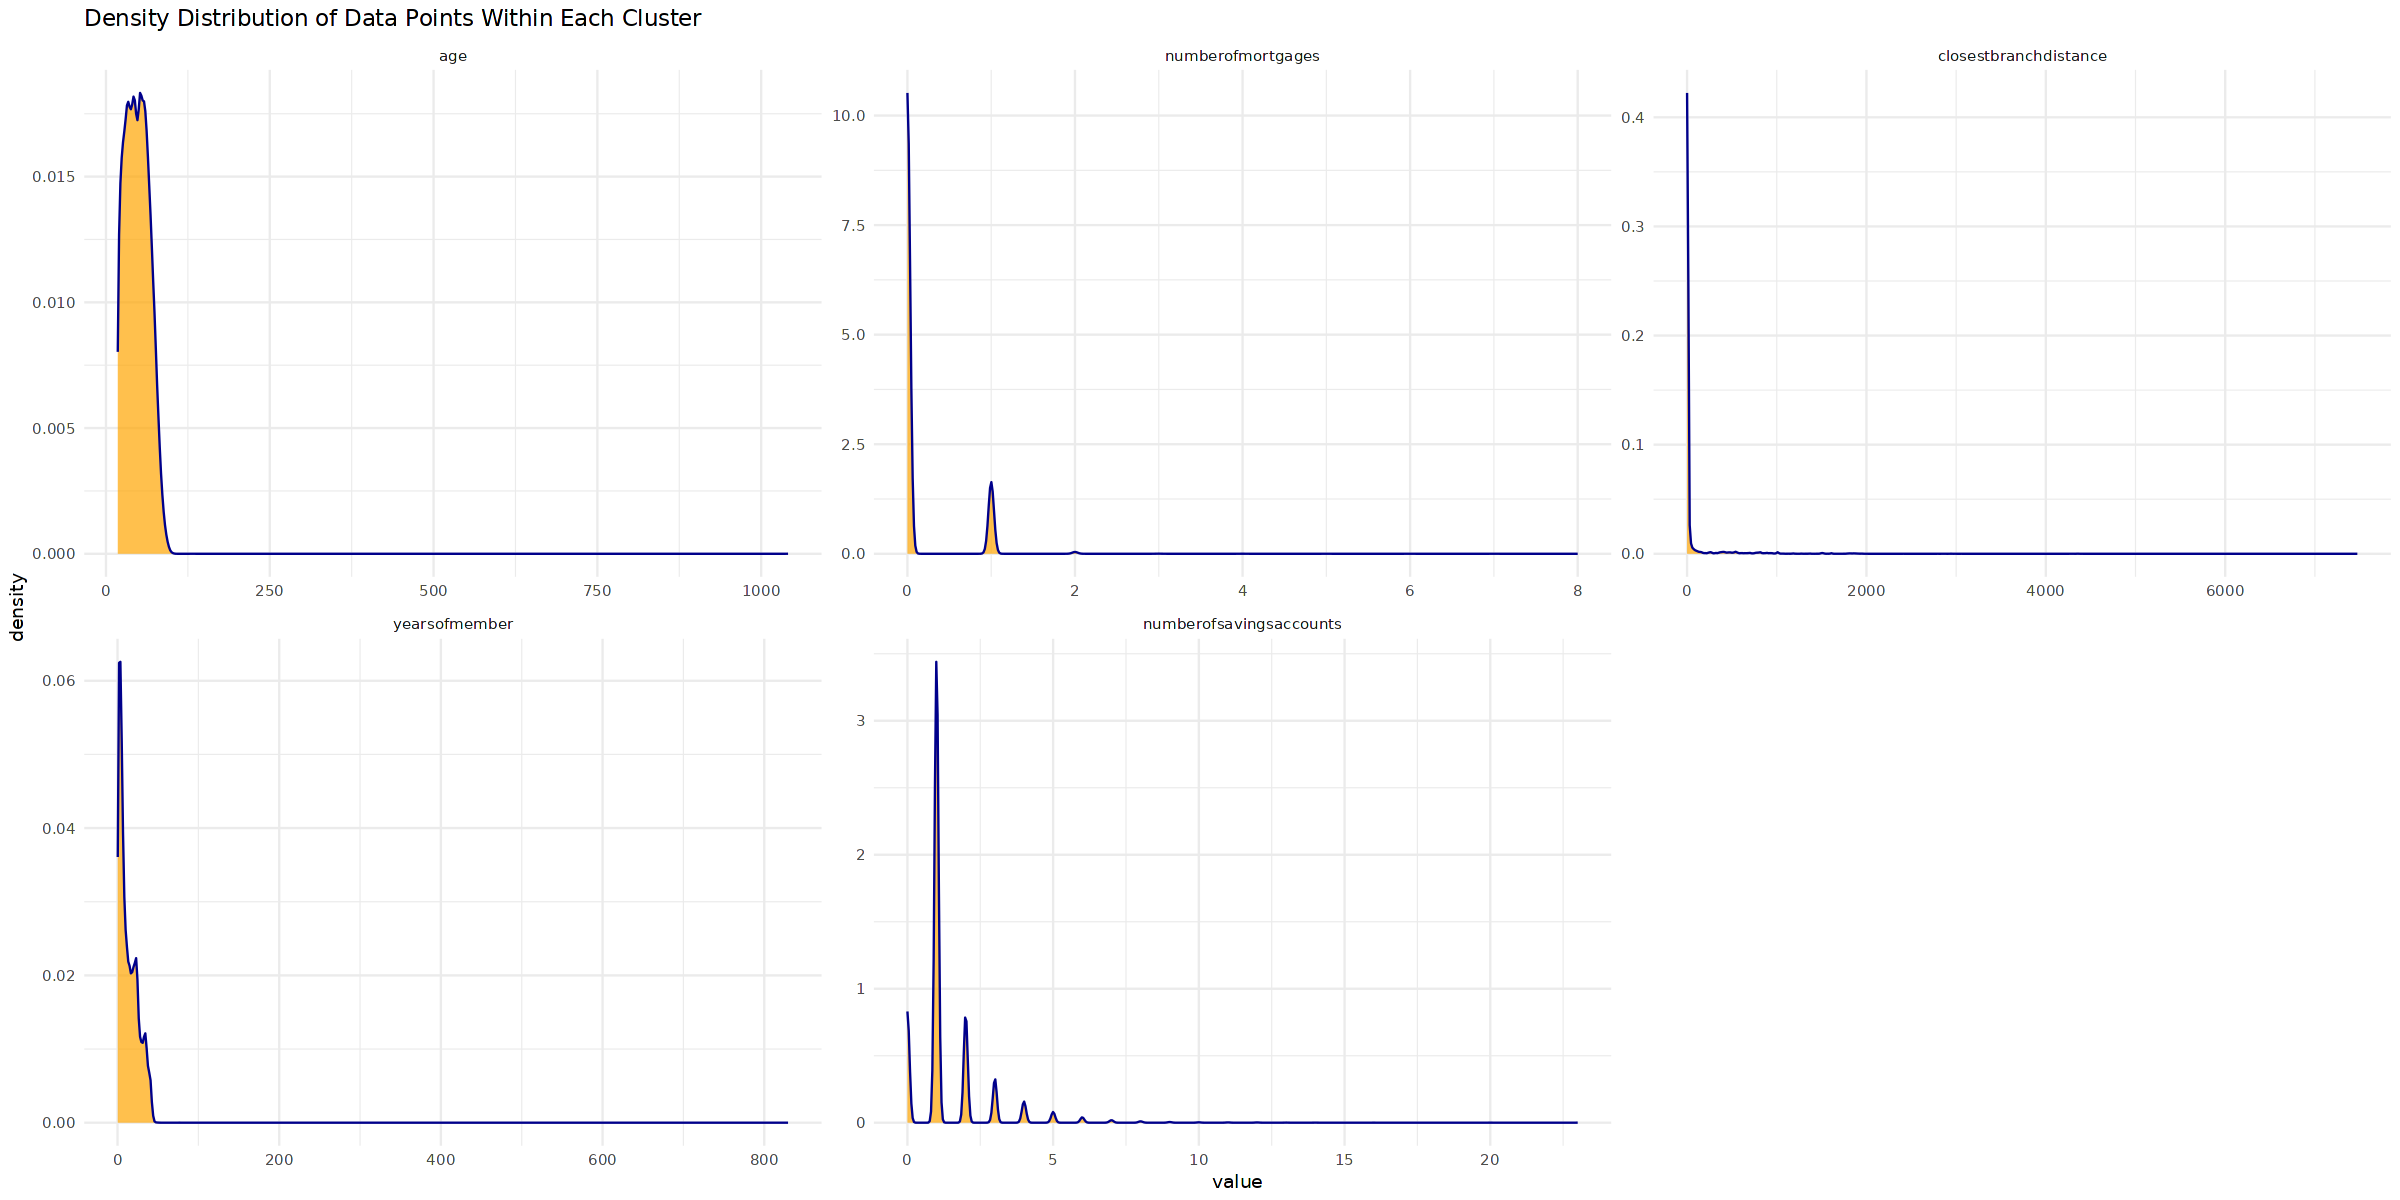

In [33]:
# Function to plot density distribution within each cluster
plot_cluster_density <- function(cluster_assignments, cluster_centers, data) {
  # Add cluster assignments to the original data
  data_with_clusters <- cbind(data, cluster = factor(cluster_assignments))
  
  # Melt the data for ggplot
  data_melted <- reshape2::melt(data_with_clusters, id.vars = "cluster")
  
  # Set plot size
  options(repr.plot.width=20, repr.plot.height=10) # Adjust width and height as needed
  
  # Plot density distribution of each cluster
  ggplot(data_melted, aes(x = value, fill = cluster)) +
    geom_density(fill = "orange", color = "darkblue", alpha = 0.7) +
    facet_wrap(~ variable, scales = "free") +
    theme_minimal() +
    labs(title = "Density Distribution of Data Points Within Each Cluster")
}

# Extract cluster assignments and cluster centers for kmeans1
cluster_assignments <- kmeans1$cluster_assignments
cluster_centers <- kmeans1$cluster_centers

# Data frame used for clustering
data <- df_KMeans1

# Plot density distribution within each cluster
plot_cluster_density(cluster_assignments, cluster_centers, data)

<h4>Summary</h4>
<p>We plot the density distribution of data points within each cluster to visualize the concentration of data points within each cluster</p>
<p>From the result of plotting `kmeans1`, we see that it closely reflects the information provided by our pairwise feature plot.</p>
<p>Based on this information, I choose to not plot the others.</p>

<h3>Parallel Coordinates Plot</h3>

<h4>Plot Parallel Coordinates of `kmeans1` clustering result</h4>

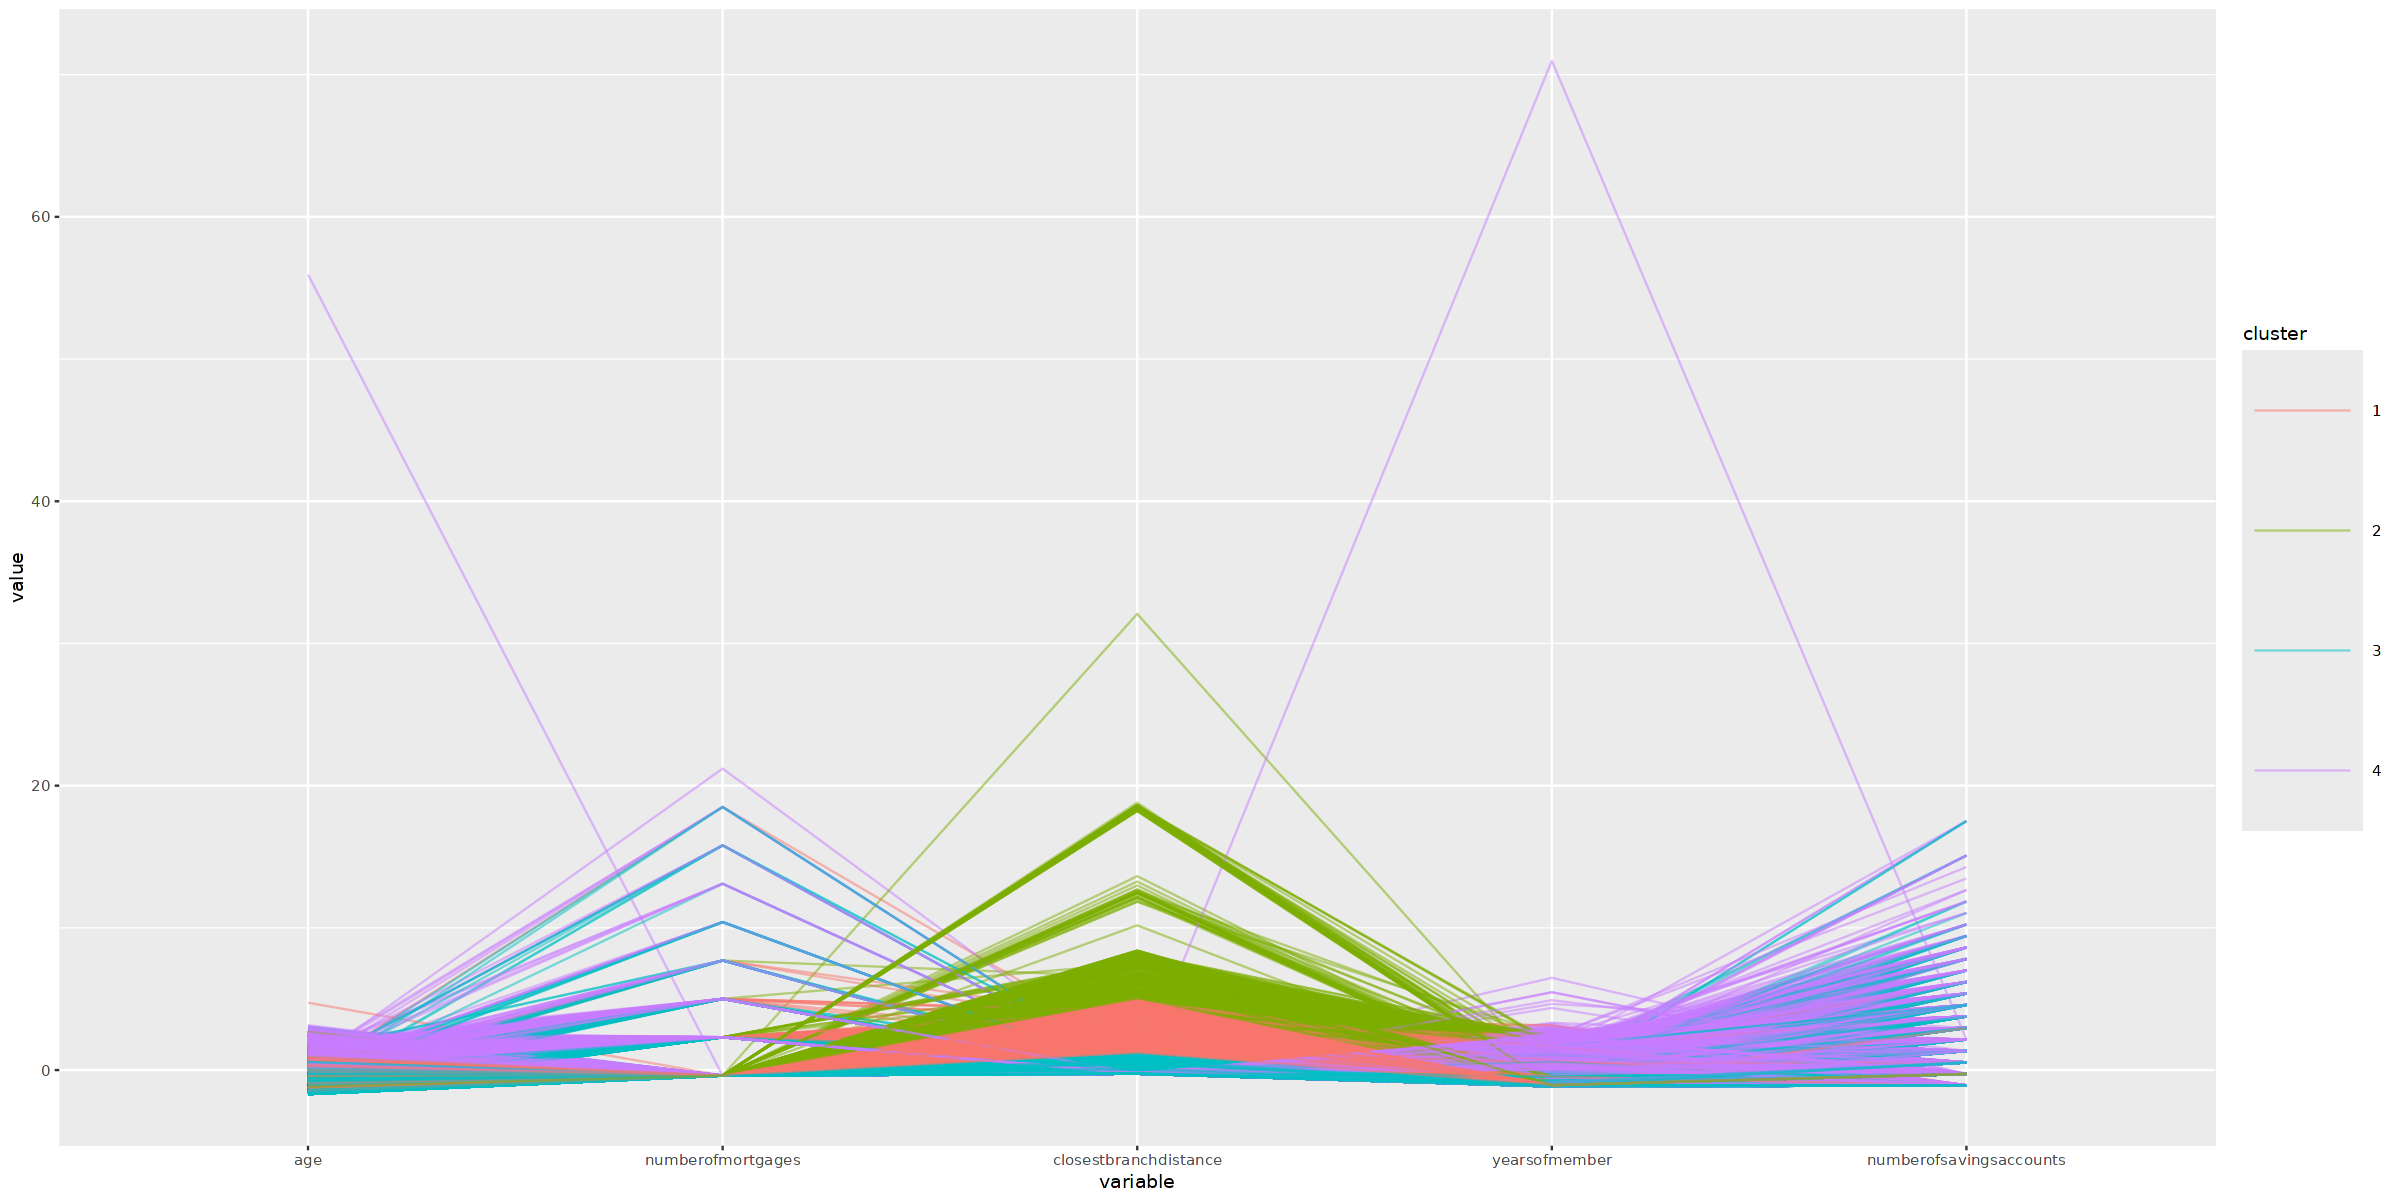

In [34]:
# Function to plot parallel coordinates
plot_parallel_coordinates <- function(kmeans_result, data) {
  # Extract cluster assignments from the kmeans_result list
  cluster_assignments <- kmeans_result$cluster_assignments
  
  # Add cluster assignments to the original data
  data_with_clusters <- cbind(data, cluster = factor(cluster_assignments))
  
  # Plot parallel coordinates
  ggparcoord(data_with_clusters, columns = 1:(ncol(data_with_clusters) - 1), 
             groupColumn = ncol(data_with_clusters), alphaLines = 0.5) + 
    theme(legend.key.size = unit(5, "lines"))
}

# Extract cluster assignments for kmeans1
cluster_assignments <- kmeans1$cluster_assignments

# Data frame used for clustering
data <- df_KMeans1

# Plot parallel coordinates
plot_parallel_coordinates(kmeans1, data)


<h4>Explanation</h4>
<p>The reasoning for using the parallel plot is to visualize the distribution/overall pattern of each cluster across multiple variables</p>
<p>The line connects each data point value across all the axes and helps us to see relationships.</p>
<p>The desire is to identify potential trends, understand similarities and structure of the data</p>

<h2>Principal Component Analysis (PCA)</h2>

<h3>Perform PCA On Unclustered Data</h3>

In [71]:
# List of data frames and their names
df_list <- list(df_KMeans1 = df_KMeans1, df_KMeans2 = df_KMeans2, 
                df_KMeans3 = df_KMeans3, df_KMeans4 = df_KMeans4)

# Initialize an empty list to store PCA results
pca_results <- list()

# Perform PCA on each dataframe and store the results
for (name in names(df_list)) {
  pca_results[[name]] <- prcomp(df_list[[name]], scale. = TRUE)
}

# Display summary of each PCA result
for (name in names(pca_results)) {
  cat("Summary of PCA result for", name, ":\n")
  print(summary(pca_results[[name]]))
  cat("\n")
}

Summary of PCA result for df_KMeans1 :
Importance of components:
                          PC1    PC2    PC3    PC4    PC5
Standard deviation     1.2317 1.0471 0.9749 0.9453 0.7363
Proportion of Variance 0.3034 0.2193 0.1901 0.1787 0.1084
Cumulative Proportion  0.3034 0.5227 0.7128 0.8916 1.0000

Summary of PCA result for df_KMeans2 :
Importance of components:
                          PC1    PC2    PC3    PC4
Standard deviation     1.3092 0.9687 0.8750 0.7630
Proportion of Variance 0.4285 0.2346 0.1914 0.1455
Cumulative Proportion  0.4285 0.6631 0.8545 1.0000

Summary of PCA result for df_KMeans3 :
Importance of components:
                          PC1    PC2    PC3     PC4
Standard deviation     1.3633 1.0185 0.9513 0.44605
Proportion of Variance 0.4647 0.2593 0.2263 0.04974
Cumulative Proportion  0.4647 0.7240 0.9503 1.00000

Summary of PCA result for df_KMeans4 :
Importance of components:
                          PC1    PC2    PC3    PC4
Standard deviation     1.1661 0.9951 0.914

<h3>Visualize Correlation Circle and Individuals Plot Side-by-Side</h3>

<h4>Explanation</h4>
<p>By analyzing these plots, we can gain insights into the structure of the data and the relative importance of the variables in explaining the variance in the data.</p> 
<p>This can be particularly useful for identifying the most important features or variables in the dataset</p> 
<p>It can also help us in understanding the relationships between the variables and the principal components.</p>


 Visualizing PCA results for df_KMeans1 :


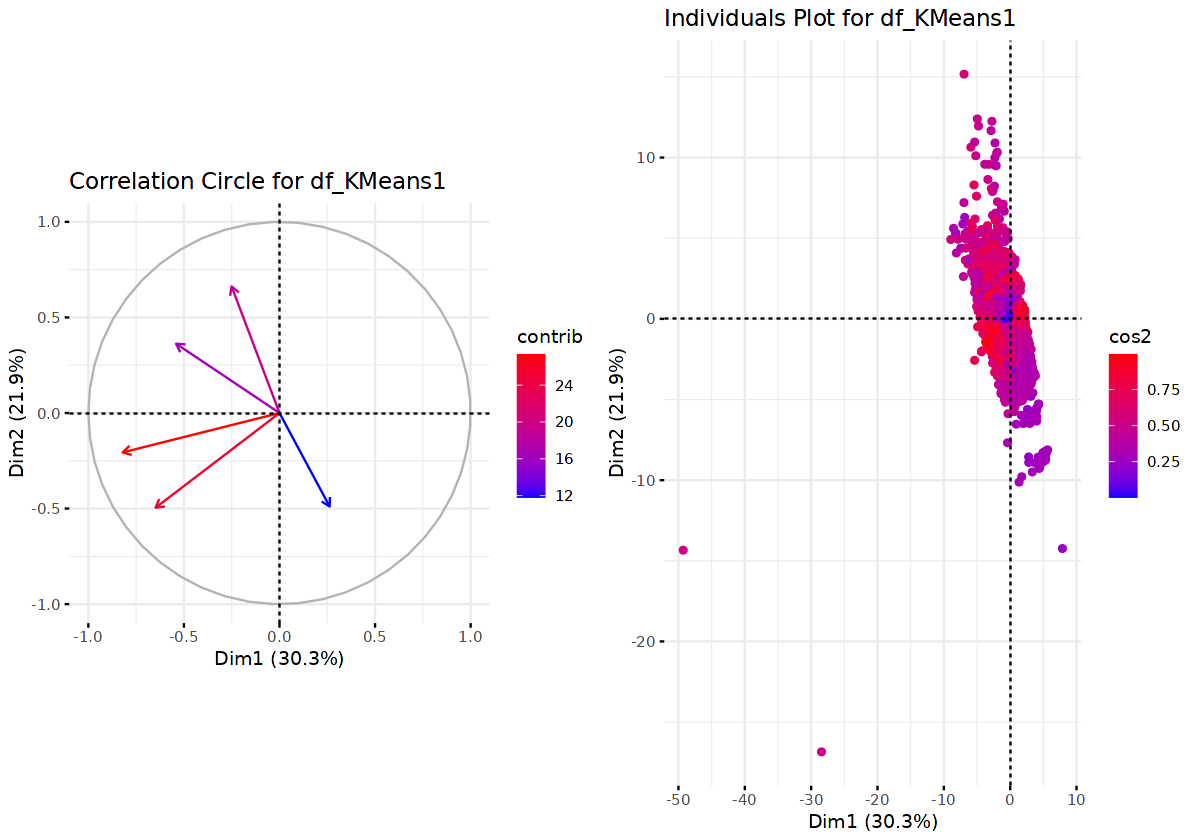


 Visualizing PCA results for df_KMeans2 :


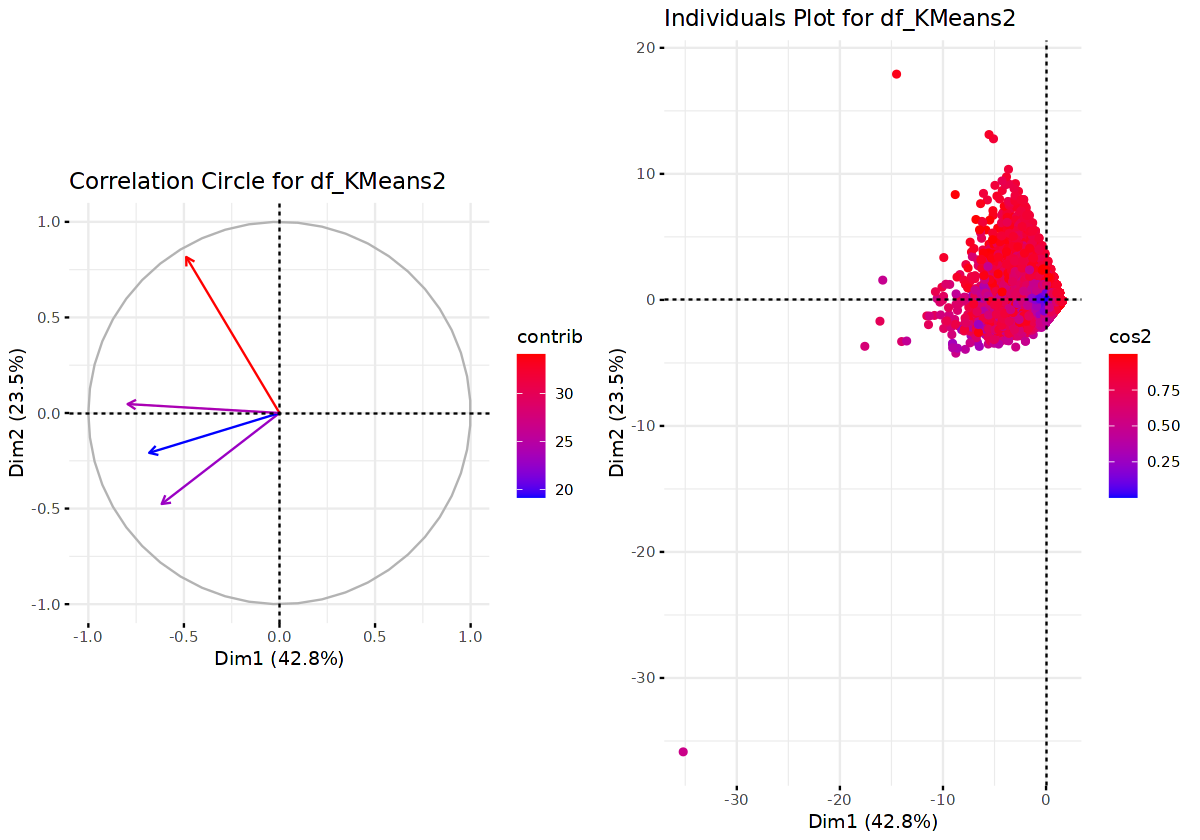


 Visualizing PCA results for df_KMeans3 :


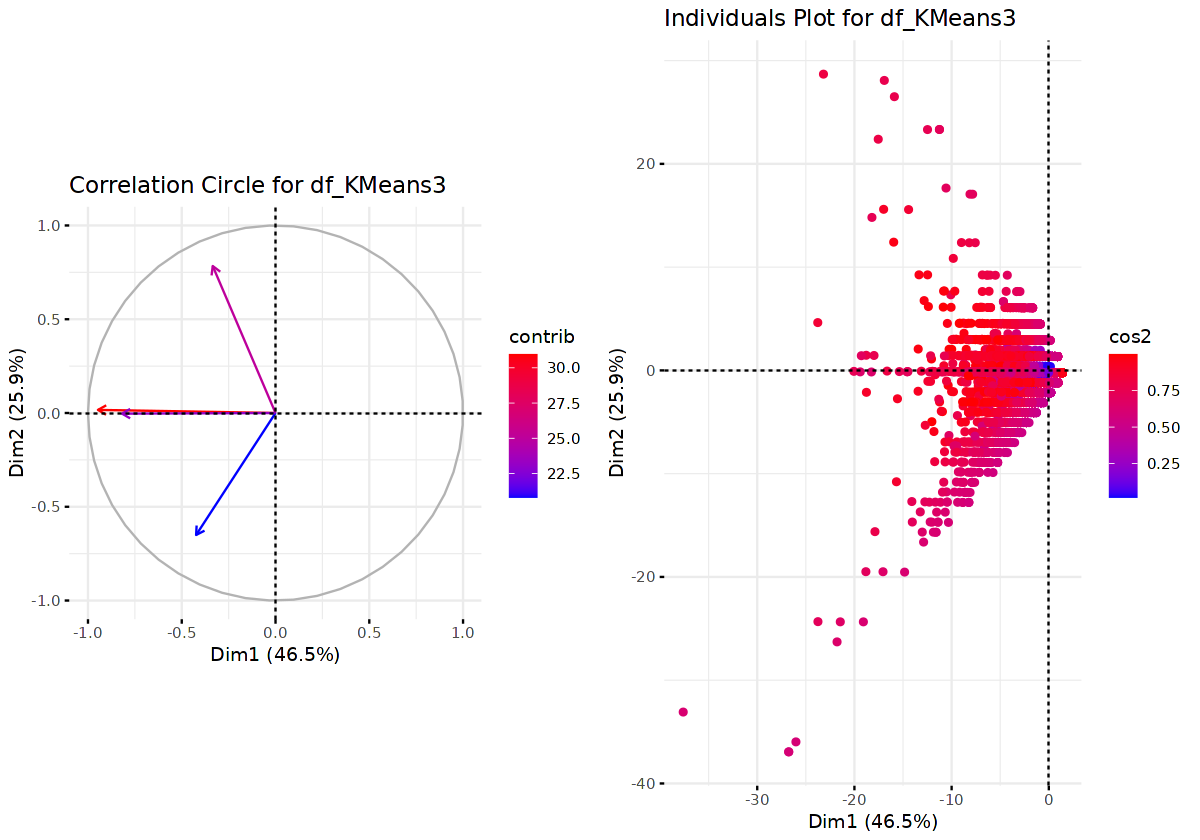


 Visualizing PCA results for df_KMeans4 :


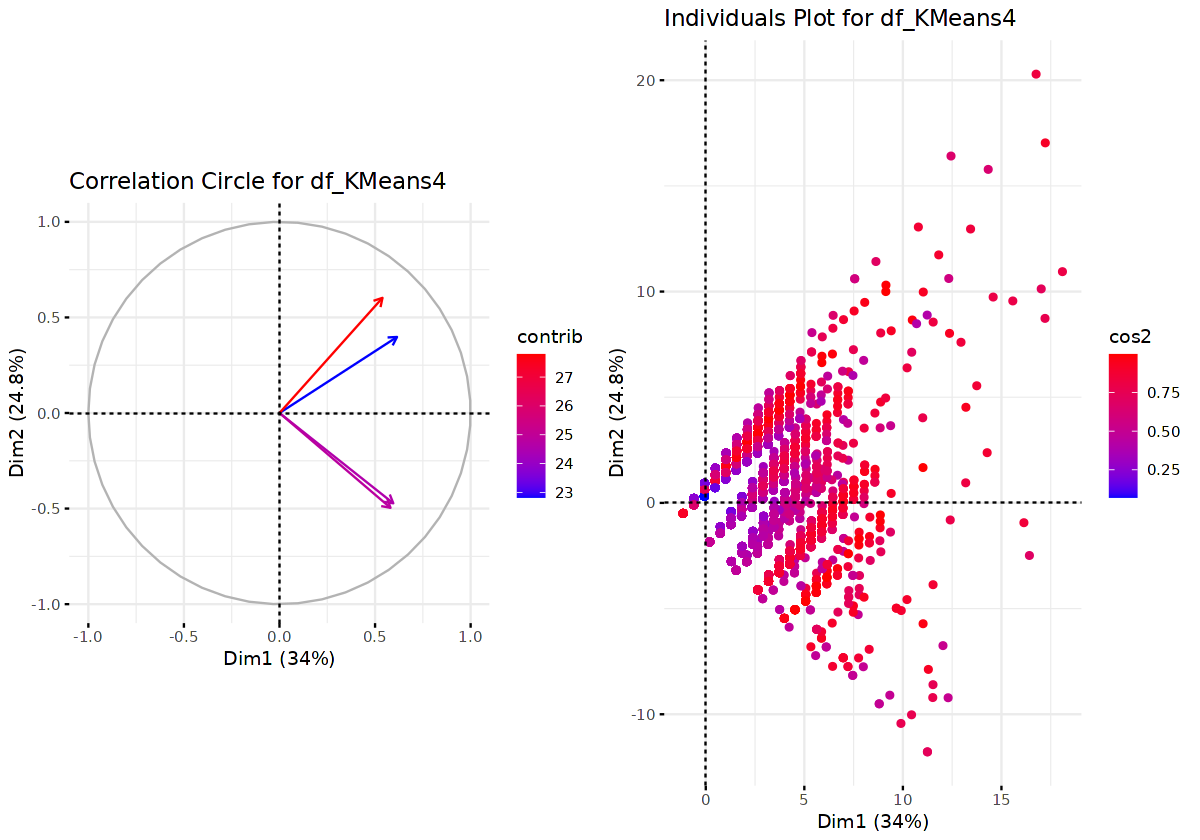

In [114]:
# Create a loop of the `pca_results`
for (name in names(pca_results)) {
  
  pca_result <- pca_results[[name]]
  
  # Get variable names
  var_names <- colnames(pca_result$rotation)
  
  # Get PC names
  pc_names <- paste("PC", seq_len(ncol(pca_result$x)))
  
  # Correlation circle plot
  corr_circle <- fviz_pca_var(pca_result, geom = "arrow", col.var = "contrib",
                              gradient.cols = c("blue", "red"), repel = TRUE,
                              title = paste("Correlation Circle for", name))
  
  # Individuals plot
  individuals_plot <- fviz_pca_ind(pca_result, geom = "point", col.ind = "cos2", 
                                   gradient.cols = c("blue", "red"),
                                   title = paste("Individuals Plot for", name))
  
  # Display the plots side by side using grid.arrange
  grid.arrange(corr_circle, individuals_plot, ncol = 2)
    
  cat("\n", "Visualizing PCA results for", name, ":\n")
}

<h4>Summary</h4>
<p><strong>Correlation Circle Plot</strong> helps us to identify the variables that are most strongly correlated with the principal components.</p> 
<p>Variables with longer arrows are more strongly correlated with the principal components, and the direction of the arrows indicates the direction of the correlation.</p>
<br/>
<p><strong>Individuals Plot</strong> helps us to visualize the distribution of the data points (individuals) in the principal component space.</p> 
<p>The color of the points will indicate the quality of representation of each data point on the principal components, with points closer to the center being better represented.</p>

<h3>Perform PCA on Clustered Data</h3>
<p><strong>Note:</strong> Using the result of the cluster profile will produce similar result but the plot is more chaotic</p>
<p><em>The PCA is performed on each subset instead of on the entire dataset due to kernel crashing issues with anvil as well as disimilarities with the number of columns of matrices</p>

<h4>Perform PCA on `kmeans1` cluster centers</h4>

Importance of components:
                          PC1    PC2     PC3                   PC4
Standard deviation     1.8874 1.1015 0.47358 0.0000000000000006833
Proportion of Variance 0.7125 0.2427 0.04486 0.0000000000000000000
Cumulative Proportion  0.7125 0.9551 1.00000 1.0000000000000000000

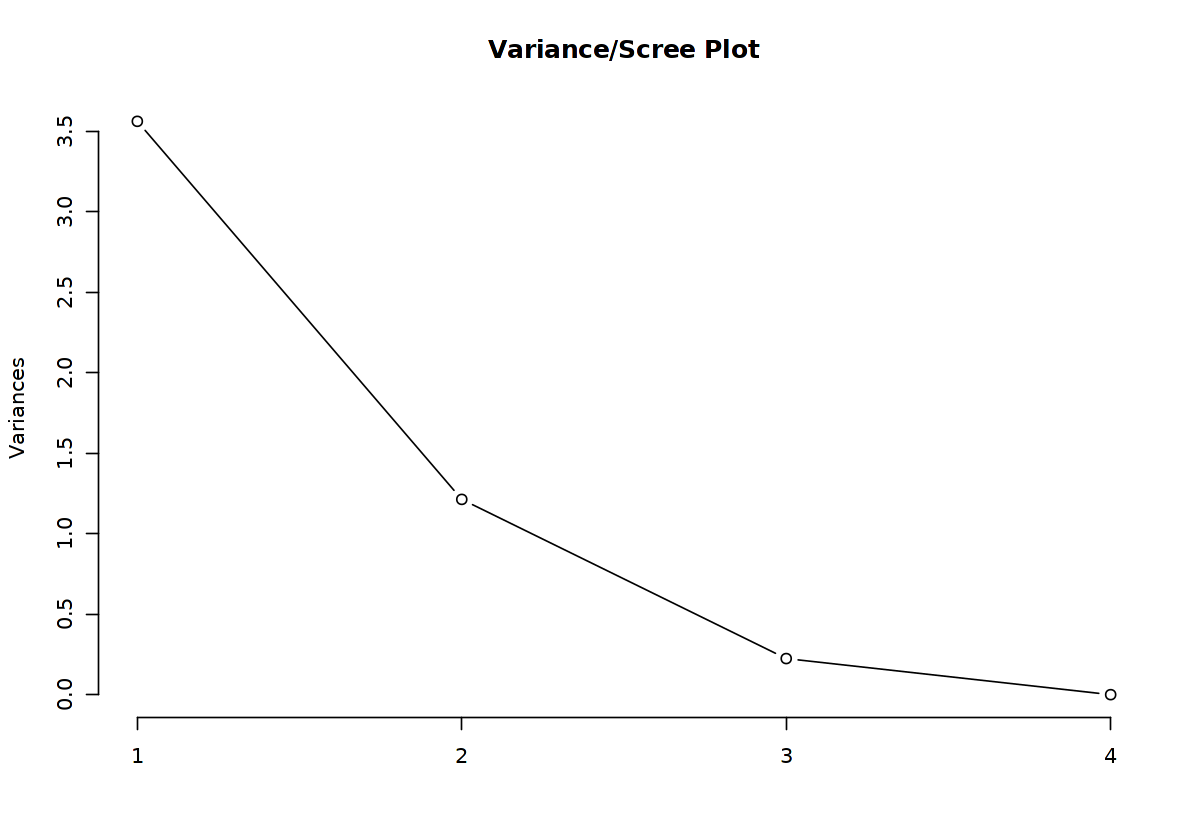

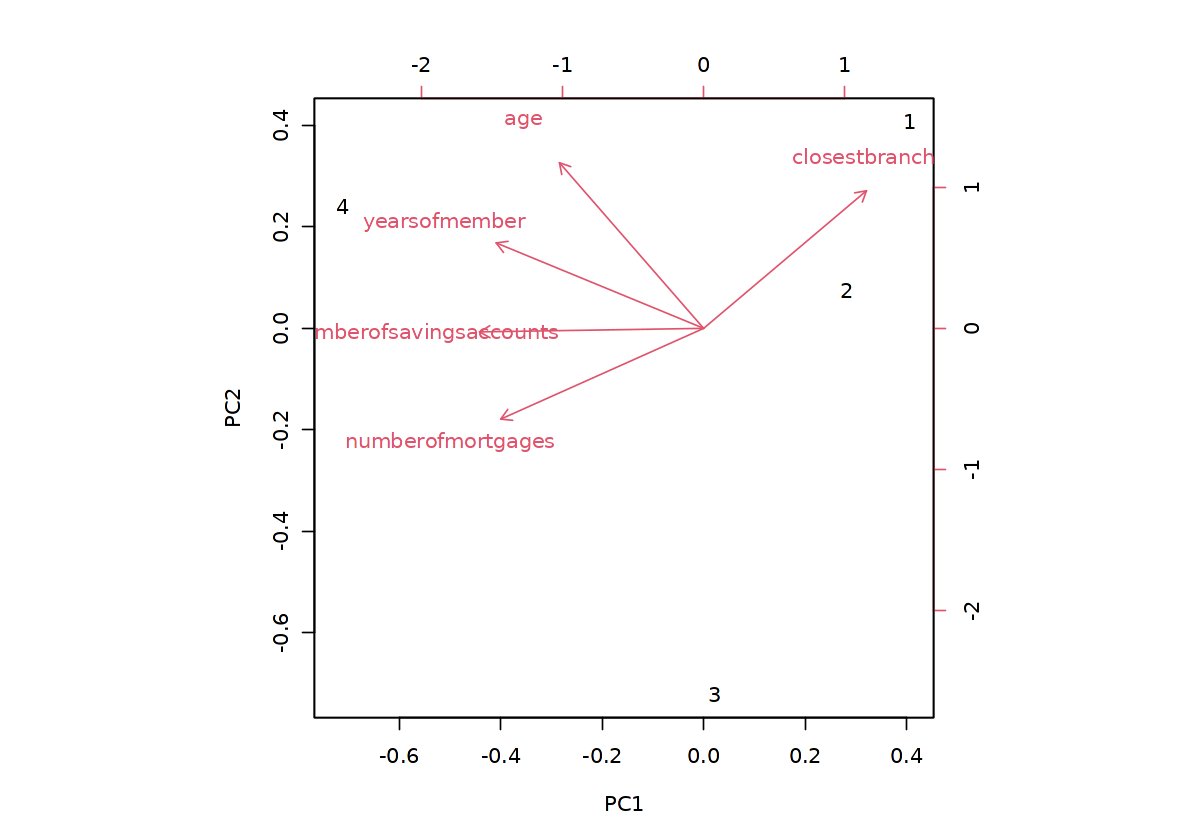

In [92]:
# Perform PCA on `kmeans1`
pca_result <- prcomp(kmeans1$cluster_centers, scale. = TRUE)

# Summary of PCA results
summary(pca_result)

# Set plot size
options(repr.plot.width=10, repr.plot.height=7) # Adjust width and height as needed

# Scree plot
plot(pca_result, type = "l", main = "Variance/Scree Plot")

# Biplot
biplot(pca_result)

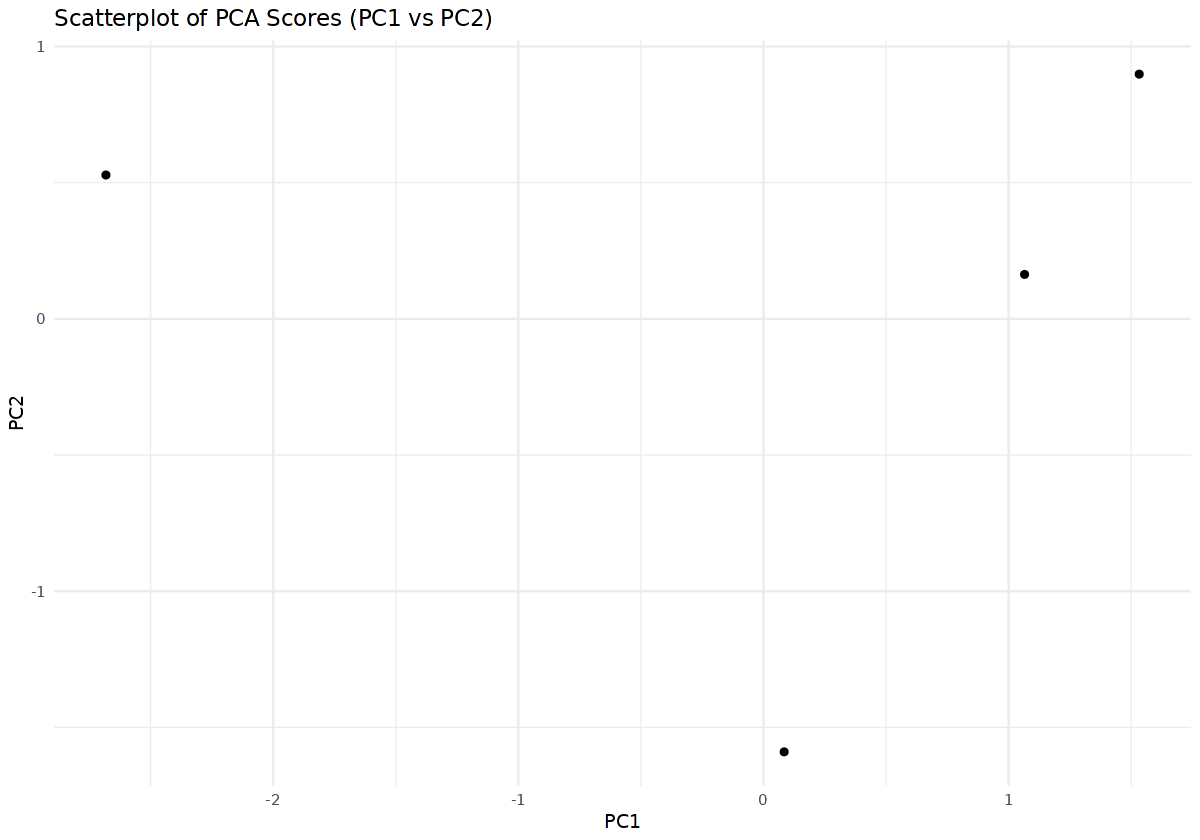

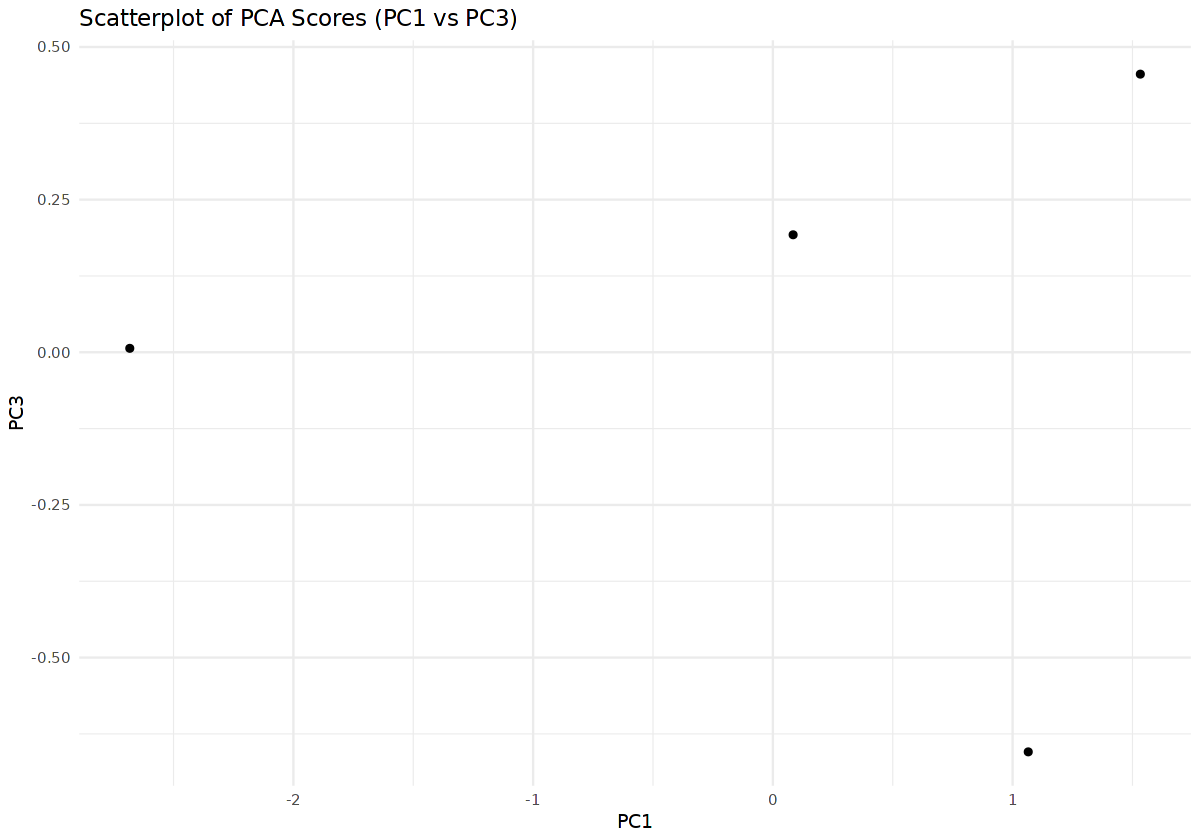

In [101]:
library(ggplot2)

# Convert PCA result to data frame
pca_df <- as.data.frame(pca_result$x)

# Create scatterplot for PC1 vs PC2
p1 <- ggplot(pca_df, aes(x = PC1, y = PC2)) +
  geom_point() +
  labs(title = "Scatterplot of PCA Scores (PC1 vs PC2)",
       x = "PC1", y = "PC2") +
  theme_minimal()

print(p1)

# Create scatterplot for PC1 vs PC3
p2 <- ggplot(pca_df, aes(x = PC1, y = PC3)) +
  geom_point() +
  labs(title = "Scatterplot of PCA Scores (PC1 vs PC3)",
       x = "PC1", y = "PC3") +
  theme_minimal()

print(p2)

<h5>Summary</h5>
<p><strong>Breakdown: </strong> 
<li>PC1 has a standard deviation of 1.8874 and explains 71.25% of the total variance in the data.</li>
<li>PC2 has a standard deviation of 1.1015 and explains 24.27% of the total variance.</li>
<li>PC3 has a standard deviation of 0.47358 and explains 4.49% of the total variance.</li>
</p>
<span>Note that PC4 is an almost negligible 0% of total variance</span>
<p>We can see from the summary of the PCA analysis on kmeans1 that the first two principal components(i.e. PC1 and PC2) capture the most important sources of variation in the data.</p>
<p>Together with PC3, these 3 explain 100% of total variance and can represent the original dataset effectively without losing much information</p>
<p><strong>Therefore, the original features with the highest absolute values on PC1 and PC2 can be considered the most important features in the df_KMeans1 subset of the data</strong></p>

<h4>Perform PCA on `kmeans2` cluster centers</h4>

Importance of components:
                          PC1    PC2     PC3                   PC4
Standard deviation     1.7588 0.9461 0.10655 0.0000000000000002062
Proportion of Variance 0.7734 0.2238 0.00284 0.0000000000000000000
Cumulative Proportion  0.7734 0.9972 1.00000 1.0000000000000000000

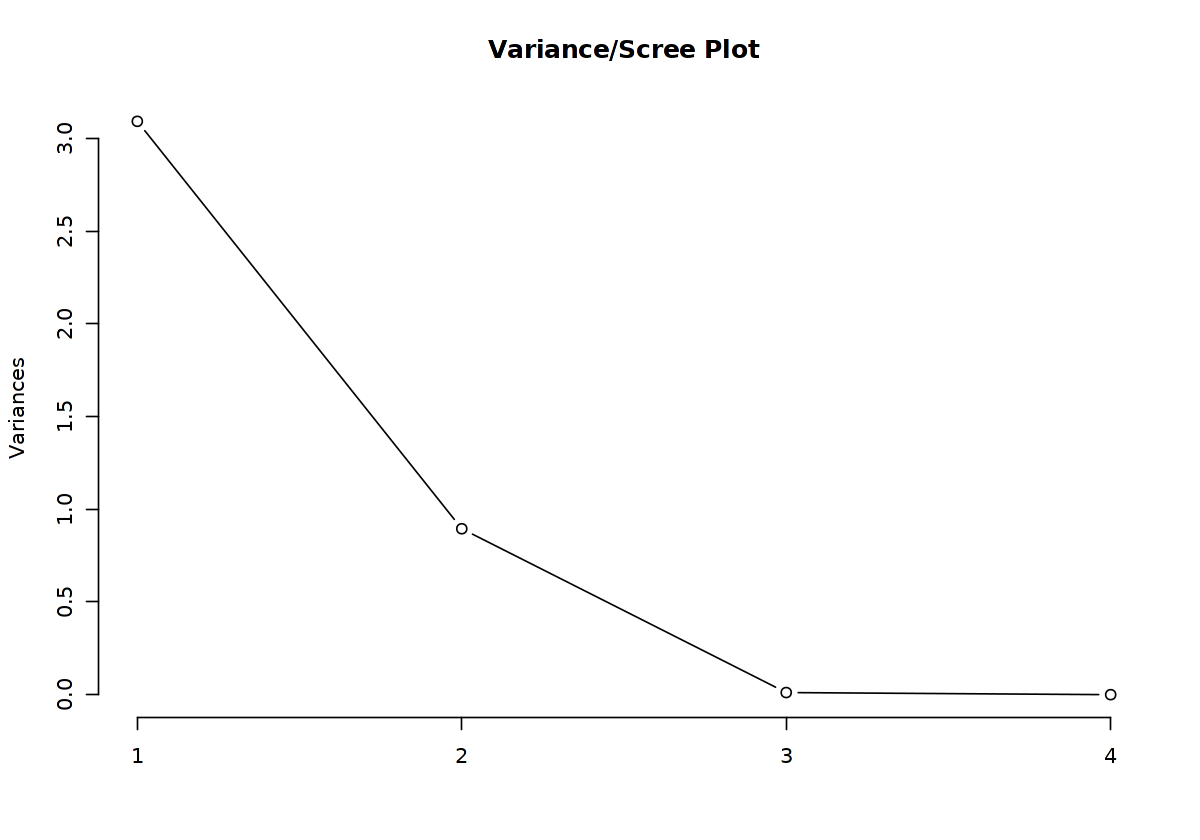

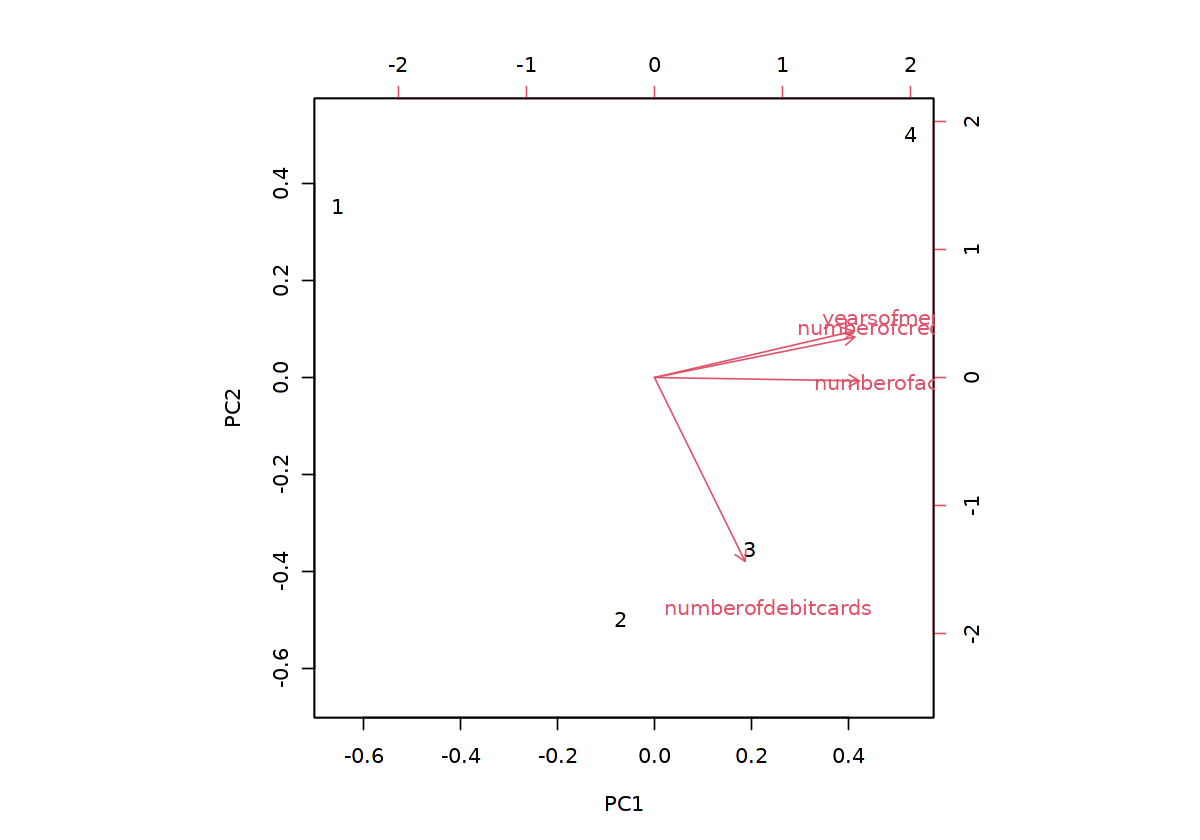

In [90]:
# Perform PCA on `kmeans2`
pca_result <- prcomp(kmeans2$cluster_centers, scale. = TRUE)

# Summary of PCA results
summary(pca_result)

# Scree plot
plot(pca_result, type = "l", main = "Variance/Scree Plot")

# Biplot
biplot(pca_result)

<h4>Perform PCA on `kmeans3` cluster centers</h4>

Importance of components:
                          PC1     PC2     PC3                    PC4
Standard deviation     1.9704 0.28108 0.19651 0.00000000000000005124
Proportion of Variance 0.9706 0.01975 0.00965 0.00000000000000000000
Cumulative Proportion  0.9706 0.99035 1.00000 1.00000000000000000000

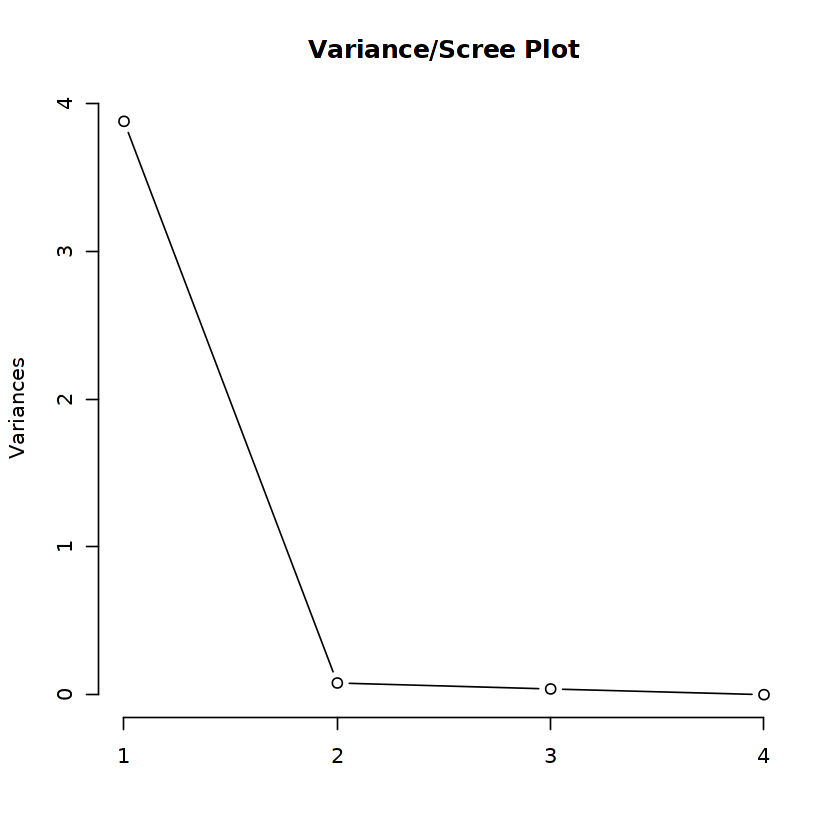

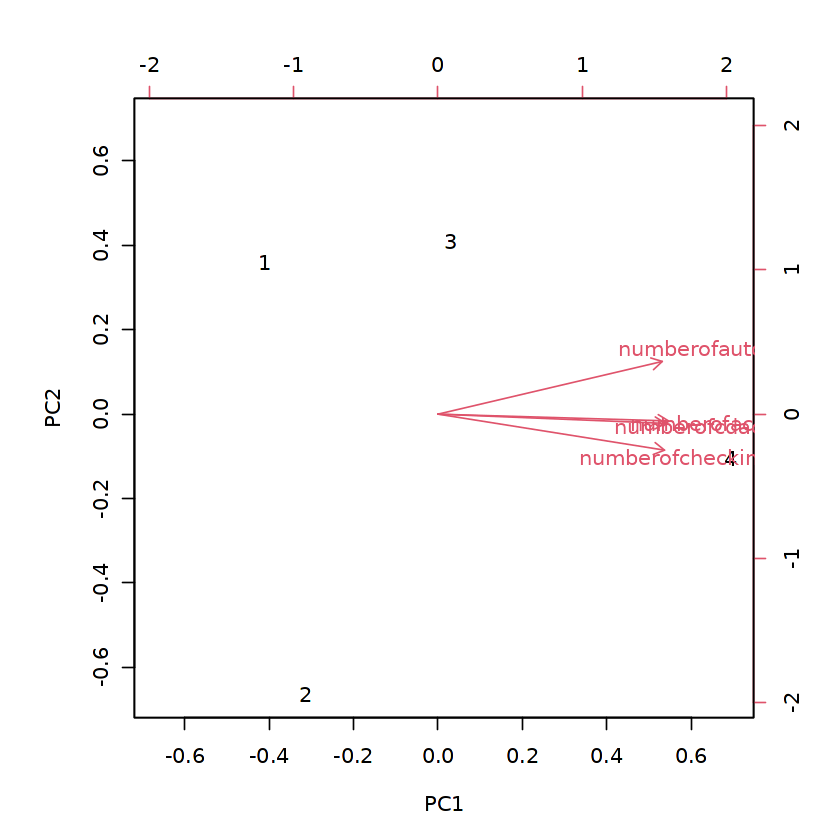

In [38]:
# Perform PCA on `kmeans3`
pca_result <- prcomp(kmeans3$cluster_centers, scale. = TRUE)

# Summary of PCA results
summary(pca_result)

# Scree plot
plot(pca_result, type = "l", main = "Variance/Scree Plot")

# Biplot
biplot(pca_result)

<h4>Perform PCA on `kmeans4` cluster centers</h4>

Importance of components:
                          PC1    PC2     PC3                   PC4
Standard deviation     1.8174 0.8302 0.08835 0.0000000000000001001
Proportion of Variance 0.8257 0.1723 0.00195 0.0000000000000000000
Cumulative Proportion  0.8257 0.9980 1.00000 1.0000000000000000000

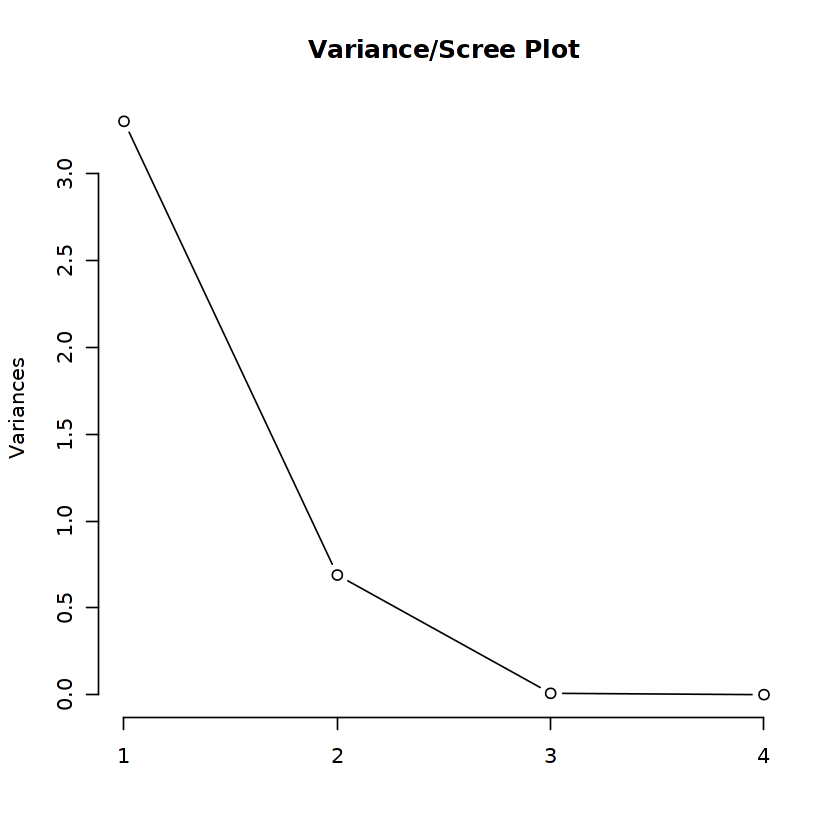

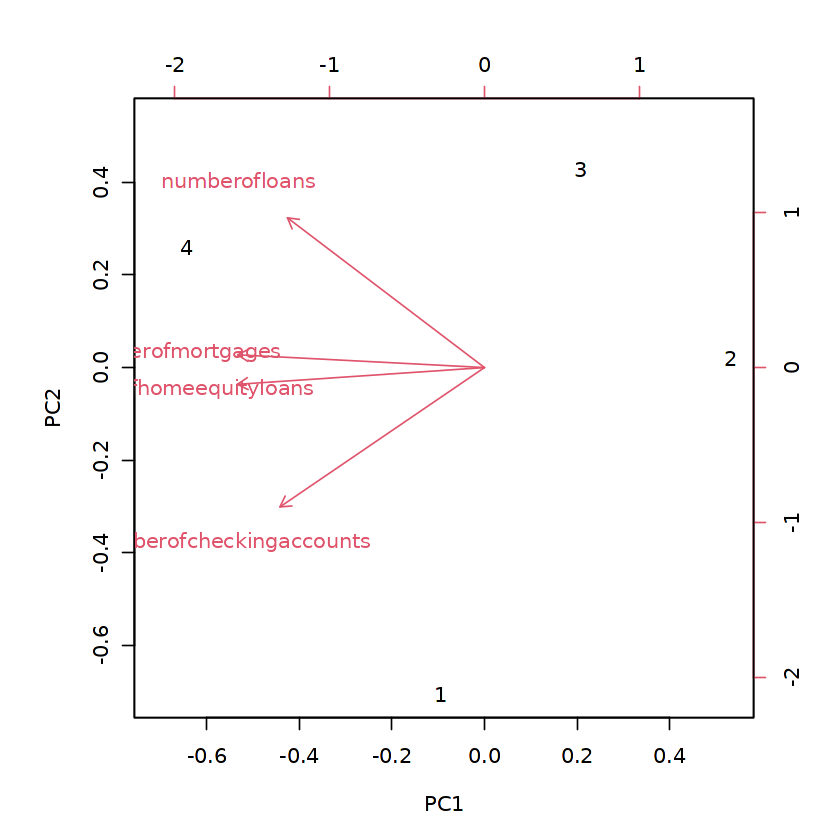

In [39]:
# Perform PCA on `kmeans4`
pca_result <- prcomp(kmeans4$cluster_centers, scale. = TRUE)

# Summary of PCA results
summary(pca_result)

# Scree plot
plot(pca_result, type = "l", main = "Variance/Scree Plot")

# Biplot
biplot(pca_result)

<h3>Perform DBSCAN on Unclustered Data</h3>
<p><strong>Note:</strong> The value you assign to the `eps` and the `minPts` will determine the result you get</p>
<p>The reason for performing this analysis is to identify noise or outliers in our data.</p>

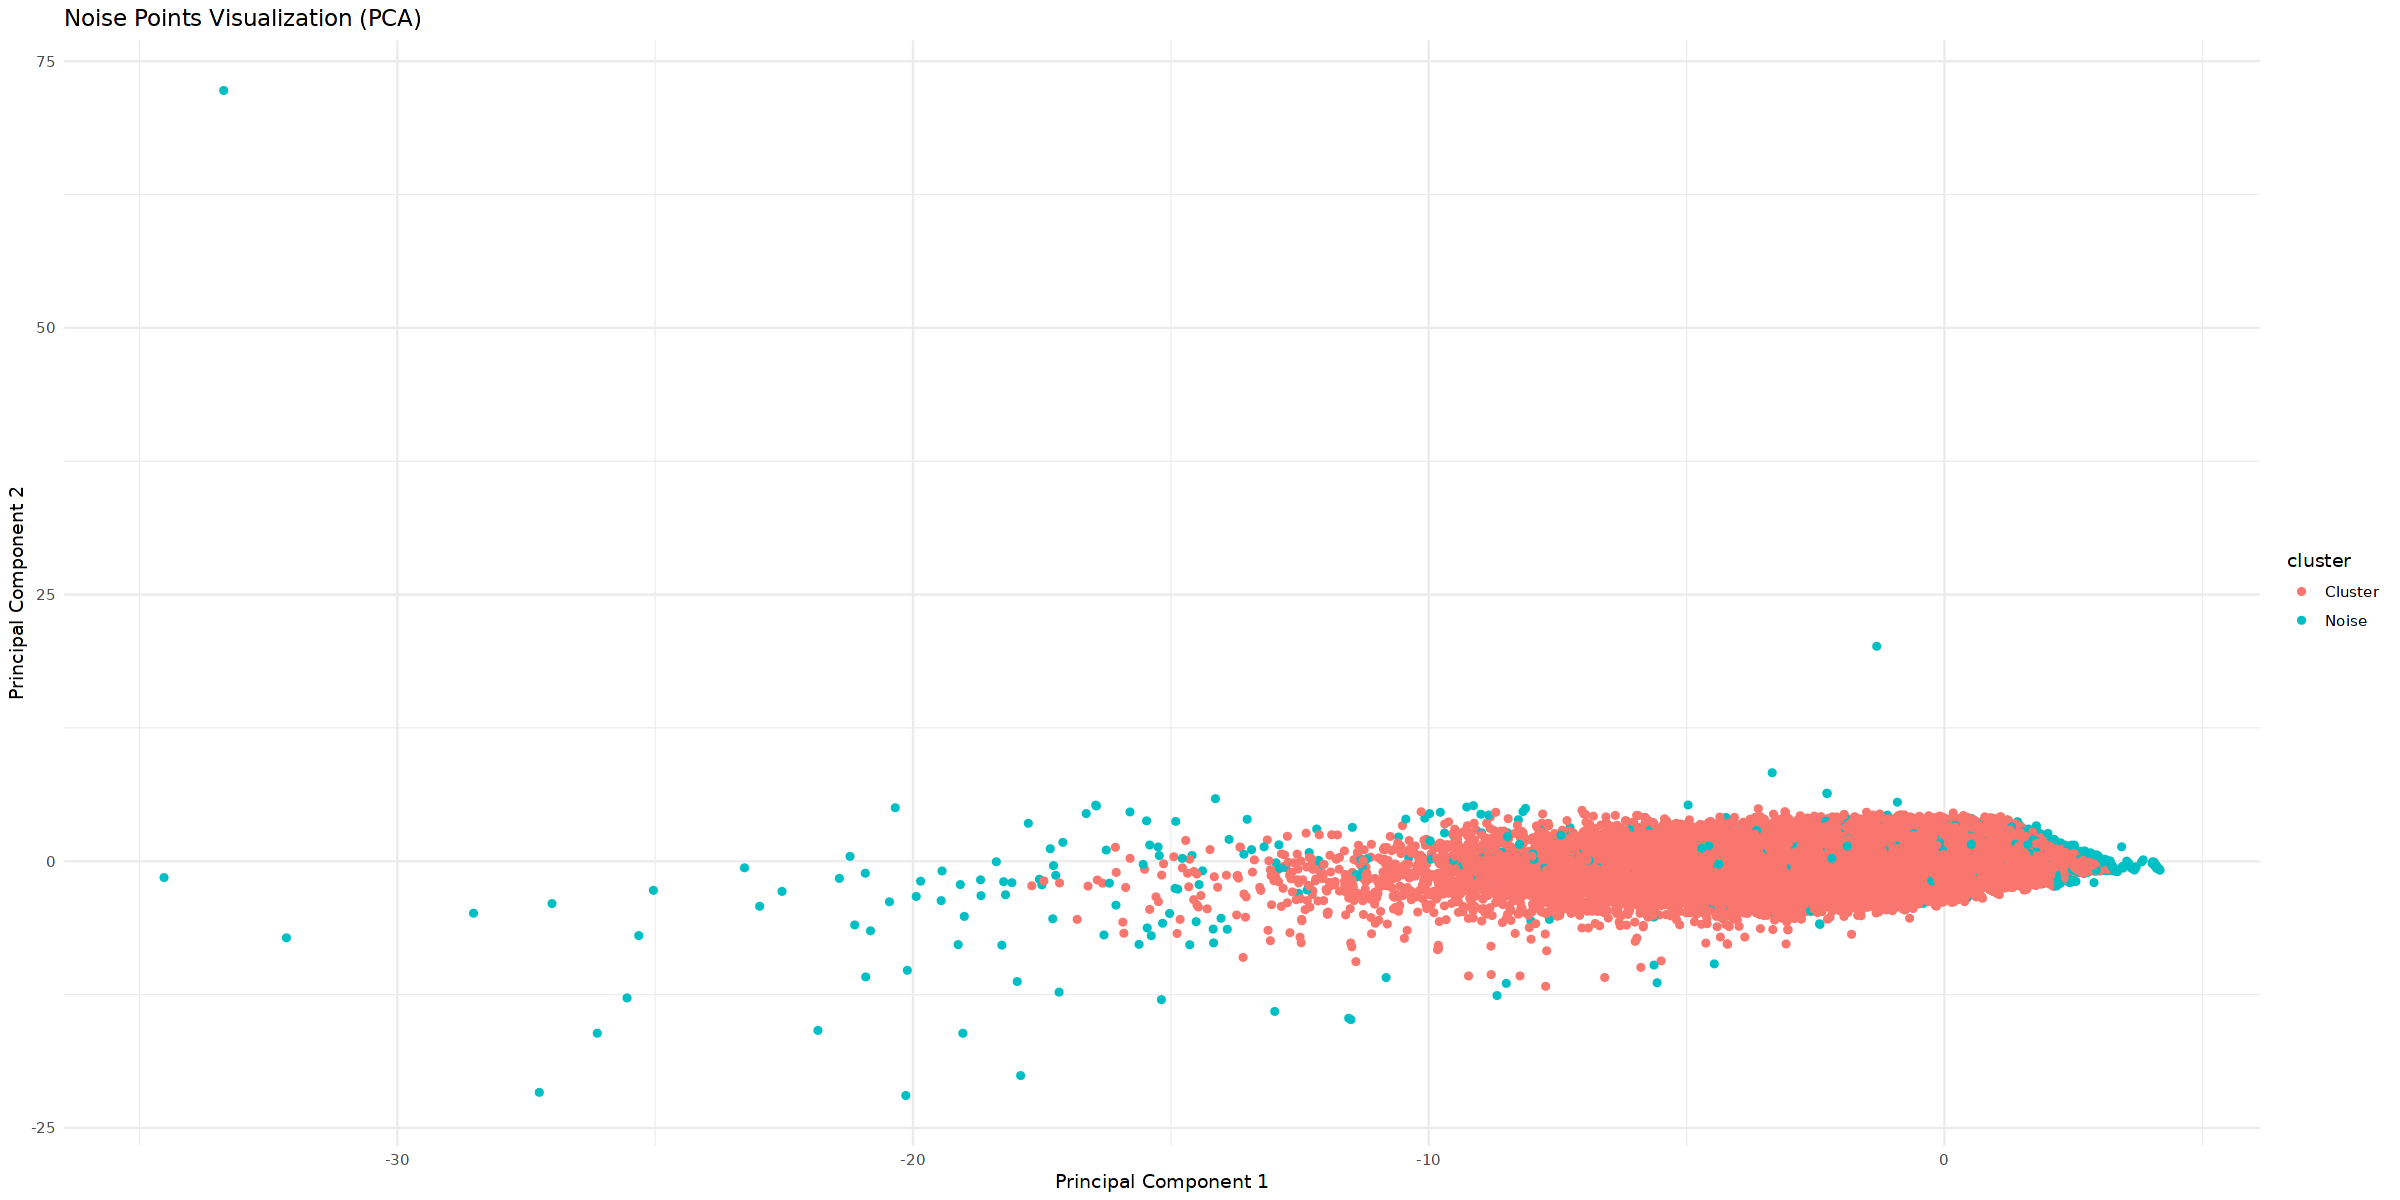

In [65]:
# Combine the data frames into a single data frame
combined_df <- cbind(df_KMeans1, df_KMeans2, df_KMeans3, df_KMeans4)

# Perform DBSCAN clustering
dbscan_result <- dbscan(combined_df, eps = 10, minPts = 25)

# describe DBSCAN clustering result
#head(dbscan_result)

# Extract cluster labels from DBSCAN result
cluster_labels <- dbscan_result$cluster

# Check if there are any noise points
if (sum(cluster_labels == 0) > 0) {
  # Extract noise points
  noise_points_indices <- which(cluster_labels == 0)
  noise_points_df <- combined_df[noise_points_indices, ]
  
  # Perform PCA on the combined dataset
  pca_result <- prcomp(combined_df, scale. = TRUE)
  pca_df <- as.data.frame(pca_result$x)
  pca_df$cluster <- factor(ifelse(cluster_labels == 0, "Noise", "Cluster"))
  
  # Visualize noise points in the first two dimensions using PCA
  ggplot(pca_df, aes(x = PC1, y = PC2, color = cluster)) +
    geom_point() +
    labs(title = "Noise Points Visualization (PCA)",
         x = "Principal Component 1",
         y = "Principal Component 2") +
    theme_minimal()
} else {
  cat("No noise points (anomalies or outliers) detected.\n")
}

<h4>Summary</h4>
<p>I determined that `eps = 10` and `minPts = 25` gave me the best visualization for the clusters and the noise points</p>
<p>Using lesser `eps` and `minPts` provided noisy visualization and in some cases the clusters were not visibly distinct from the noisy data points.</p>
<p>However, these can be adjusted in future works and might provide valuable insights into the underlying data structure.</p>
<p>We can also see that there are varying densities in the data points as the visualzations tapers towards the right.</p>

<footer> <h1>Conclusion</h1>
<p>In the multivariate analysis of the customer data, the question remains - <strong>should we perform k-means clustering before the PCA or vice versa.</strong></p>
<p>In this analysis, I have choosen the go with <strong>k-means clustering before PCA</strong> because the results were easier to interpret than the other</p>
<p>Other analyses performed are 
<li>DBSCAN</li>
<p>We can see that several types of visualizations are performed and some of them are for different purposes, namely 
<li>To understand the data</li>
<li>To Verify that the algorithm was successful</li>
<li>To understand the relationship between variables</li>
<li>To identify noise patterns and outliers</li>
<li>To visualize overall patterns</li>
</p>
</footer>